Идея:
* Попробовать строить модели с большим числом тем и включать регуляризатор отбора тем
* регуляризатор отбора тем нельзя включать сразу
* регуляризатор отбора тем нельзя включать вместе с регуляризатором декоррелирования


In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

pd.options.display.max_rows = 999

0.8.1


In [2]:
config = ConfigPaths('config_sample_m2.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model2\np_28_03_2_300\models.txt


In [3]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [18]:
phi_original, theta_original = load_pickle_file('phi_model2.p', config.output_batches_path), load_pickle_file('theta_model2.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(8051, 100) (100, 3446)


In [4]:
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original)
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test)
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')


        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)
    
def experiment_result_to_df(different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
                            different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix, init_num_topics,
                            first_index):
    def get_result_by_distance_and_th(different_fns_ths, dist_fn, th):
        if th not in different_fns_ths[dist_fn][1].keys():
            tmp = [(key, abs(key - th)) for key in different_fns_ths[dist_fn][1].keys()]
            tmp = sorted(tmp, key=lambda x: x[1])
            th = tmp[0][0]
        return different_fns_ths[dist_fn][1][th]
    def res_to_str(different_fns_ths, th):
        j_res = len(get_result_by_distance_and_th(different_fns_ths, dh.jaccard_dist, th))
        h_res = len(get_result_by_distance_and_th(different_fns_ths, dh.hellinger_dist, th))
        if j_res == h_res:
            res = 'jh{}'.format(j_res)
        else:
            res = 'j{}-h{}'.format(j_res, h_res)
        return res
    def get_second_index(init_num_topics, models_compare_matrix):
        num_topics = models_compare_matrix.loc['num topics', 'phi_2']
        zero_ratio = models_compare_matrix.loc['non zero ratio', 'phi_2']
        return '{0} -> {1:0.0f}, {2:0.2f}'.format(init_num_topics, num_topics, zero_ratio)
    def get_second_line(models_compare_matrix):
        def get_quantile_res(models_compare_matrix, index_name):
            tmp1 = models_compare_matrix.loc[index_name, 'phi_1']
            tmp2 = models_compare_matrix.loc[index_name, 'phi_2']
            is_diff = abs(tmp1 - tmp2) / tmp1 < 0.3
            res = '+' if is_diff else '-'
            return res
        avg_size = models_compare_matrix.loc['topic_kernel_average_size', 'phi_2']
        avg_purity = models_compare_matrix.loc['topic_kernel_average_purity', 'phi_2']
        avg_contrast = models_compare_matrix.loc['topic_kernel_average_contrast', 'phi_2']
        indices_names = ['|phi_ij > 0.2| / n_topics', '|phi_ij > 0.1| / n_topics', '|phi_ij > 0.01| / n_topics',
                         '|phi_ij > 0.05| / n_topics', '|phi_ij > 0.001| / n_topics']
        compare_quantile = ''.join([get_quantile_res(models_compare_matrix, index_name) for index_name in indices_names])
        res = ['24 vs {0:0.0f}'.format(avg_size), '.63 vs {0:.2f}'.format(avg_purity), '.78 vs {0:.2f}'.format(avg_contrast), compare_quantile]
        return res
    
    df = pd.DataFrame(0, columns=[0.2, 0.4, 0.6, 0.8], index = [])
    df.loc[first_index] = ['-', '-', '-', '-']
    second_index = get_second_index(init_num_topics, models_compare_matrix)
    second_line = get_second_line(models_compare_matrix)
    df.loc[second_index] = second_line 
    for th in [0.2, 0.4, 0.6, 0.8]:
        df.loc['closest by dist test/original', th] = res_to_str(different_to_original_distances_closest_1, th)
        df.loc['closest by dist original/test', th] = res_to_str(different_to_test_distances_closest_2, th)
        df.loc['closest by opt res test/original', th] = res_to_str(different_to_original_opts_1, th)
        df.loc['closest by opt res original/test', th] = res_to_str(different_to_test_opts_2, th)
    return df

# Choose models
Построить несколько моделей с отбором тем. Выводить число оставшихся необнулившихся колонок фи/тета.

In [8]:
N_TOPICS = 300

models_count = 100
names_list, models_list = [0] * models_count, [0] * models_count
phi_list, phi_nwt_list, theta_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list = [0] * models_count, [0] * models_count, [0] * models_count
result_dfs = [0] * models_count

different_inter_distances_closest_1, different_inter_distances_closest_2 = [0] * models_count, [0] * models_count
different_inter_distances_1, different_inter_distances_2 = [0] * models_count, [0] * models_count
different_to_original_distances_closest_1, different_to_test_distances_closest_2 = [0] * models_count, [0] * models_count
different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = [0] * models_count, [0] * models_count, [0] * models_count

In [9]:
[different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix] = load_pickle_file('result_300.p')
[names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list] = load_pickle_file('init_300.p')

# 300 topics
## decorrelator only
* без обучения сначала

name = model_rch_300_1_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 1.5
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 55, [u'topic_6', u'topic_7', u'topic_12', u'topic_13', u'topic_16', u'topic_17', u'topic_20', u'topic_28', u'topic_32', u'topic_33', u'topic_35', u'topic_37', u'topic_39', u'topic_43', u'topic_71', u'topic_78', u'topic_84', u'topic_88', u'topic_117', u'topic_126', u'topic_127', u'topic_128', u'topic_129', u'topic_131', u'topic_135', u'topic_140', u'topic_142', u'topic_152', u'topic_156', u'topic_162', u'topic_164', u'topic_168', u'topic_175', u'topic_179', u'topic_197', u'topic_198', u'topic_201', u'topic_202', u'topic_208', u'topic_212', u'topic_213', u'topic_214', u'topic_250', u'topic_252', u'topic_262', u'topic_263', u'topic_264', u'topic_266', u'topic_271', u'topic_274', u'topic_283', u'topic_291', u'topic_2

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00    55.00
non zero ratio                    0.96     1.00
|phi_ij == 0| / n_topics       7689.02  8011.67
|phi_ij > 0.2| / n_topics         0.03     0.60
|phi_ij > 0.1| / n_topics         0.31     2.04
|phi_ij > 0.01| / n_topics       14.64    19.64
|phi_ij > 0.05| / n_topics        1.21     4.89
|phi_ij > 0.001| / n_topics     214.17    35.69
topic_kernel_average_size        23.68    10.93
topic_kernel_average_purity       0.63     0.54
topic_kernel_average_contrast     0.78     0.70

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 55         Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function hellinger_dist at 0x000000000BF32B38>, Processed th = 1.0, original columns count = 55     

C:\Users\jluka\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 55         Column topic_17 not optimized
Column topic_26 not optimized
Column topic_29 not optimized
Column topic_43 not optimized
Dist fn = <function hellinger_dist at 0x000000000BF32B38>, Processed th = 1.0, original columns count = 55     [(u'topic_6', u'topic_35', 0, 35, 0.68022460680601071), (u'topic_7', u'topic_34', 1, 34, 0.6914599717555423), (u'topic_12', u'topic_5', 2, 5, 0.72990885704287356), (u'topic_13', u'topic_4', 3, 4, 0.81692332892660269), (u'topic_16', u'topic_7', 4, 7, 0.69532699029018374), (u'topic_17', u'topic_6', 5, 6, 0.73563835252458842), (u'topic_20', u'topic_33', 6, 33, 0.72784370460923764), (u'topic_28', u'topic_30', 7, 30, 0.7956027810203915), (u'topic_32', u'topic_1', 8, 1, 0.42407479258492881), (u'topic_33', u'topic_0', 9, 0, 0.59293670814008825), (u'topic_35', u'topic_2', 10, 2, 0.71467385057704536), (u'topic_37', u'topic_3', 11, 3, 0.65403460126526058), (u'to

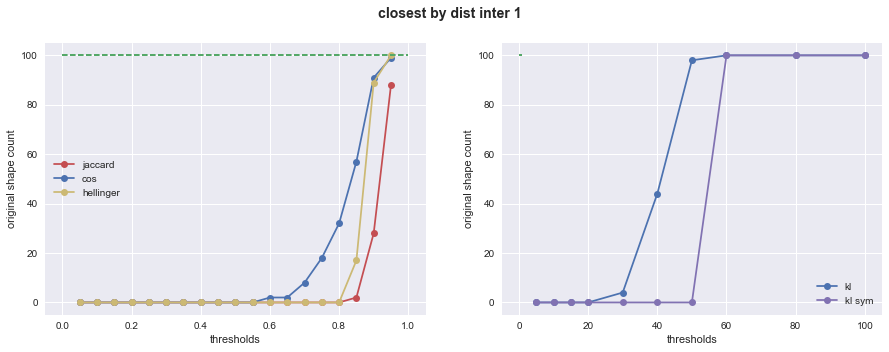

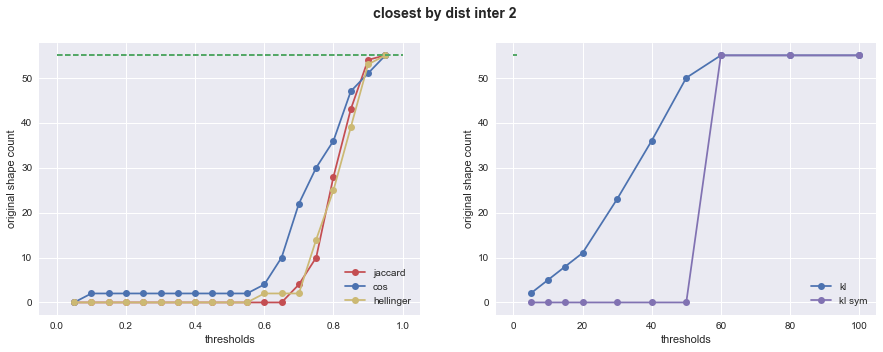

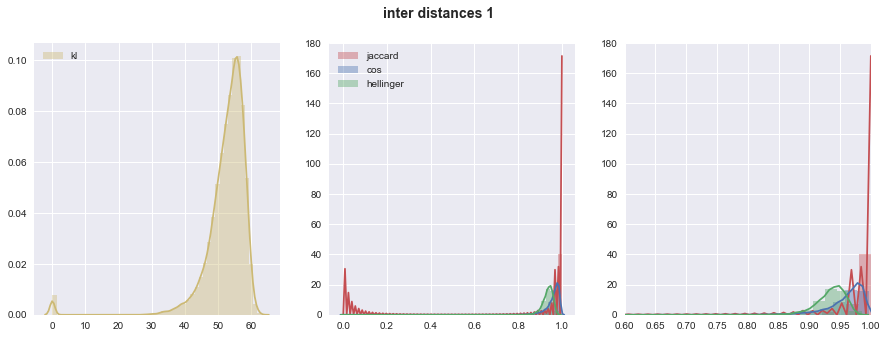

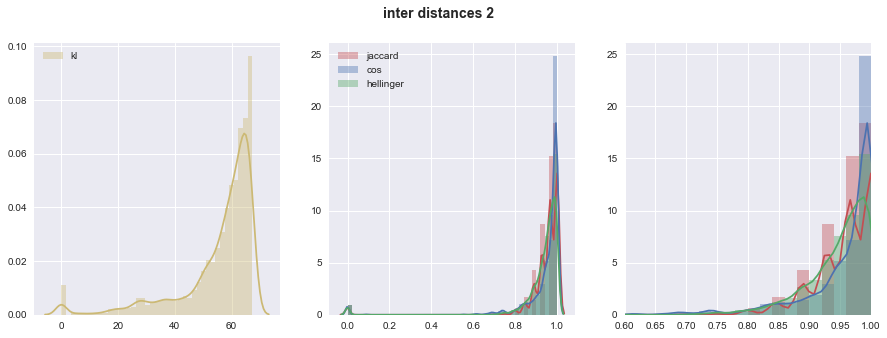

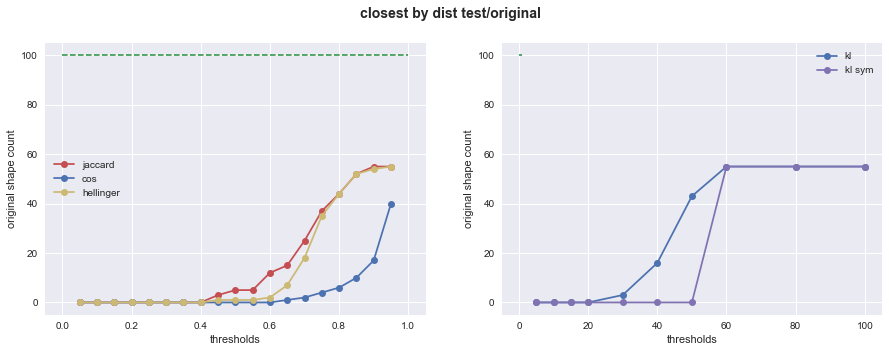

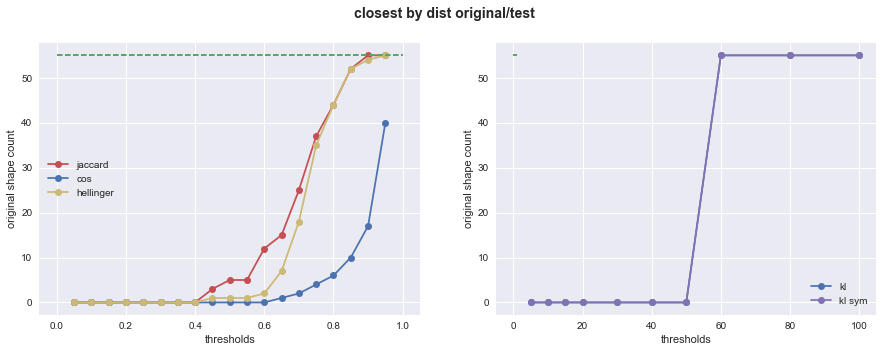

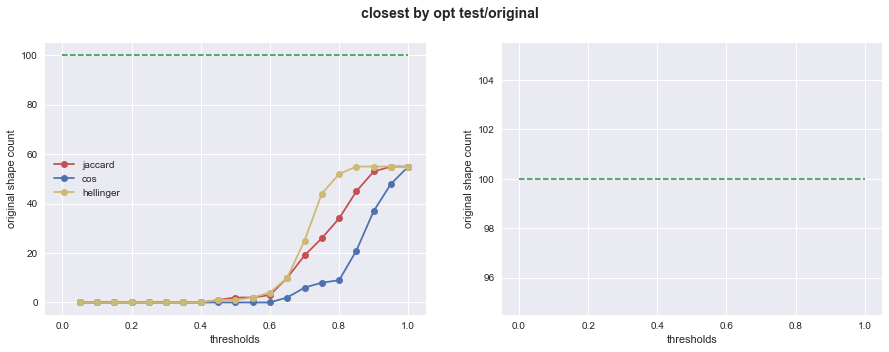

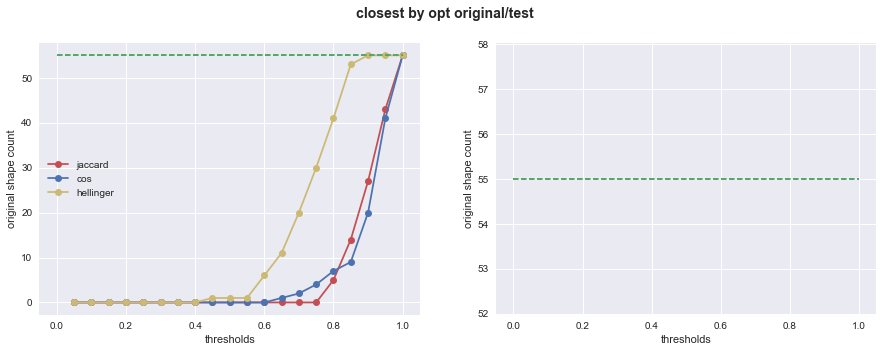

In [21]:
N_TOPICS=300

def create_model_rch_300_1(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 21
names_list[idx] = u'model_rch_300_1'
models_list[idx] = create_model_rch_300_1(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [10]:
idx = 21
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
model_rch_300_1                          -            -            -        -
300 -> 55, 1.00                   24 vs 11  .63 vs 0.54  .78 vs 0.70    -----
closest by dist test/original          jh0          jh0       j12-h2     jh44
closest by dist original/test          jh0          jh0       j12-h2     jh44
closest by opt res test/original       jh0          jh0        j3-h4  j34-h52
closest by opt res original/test       jh0          jh0        j0-h6   j5-h41

name = model_rch_300_2_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_2_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 3
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 198, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_20', u'topic_21', u'topic_22', u'topic_24', u'topic_26', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_55', u't

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   198.00
non zero ratio                    0.96     0.99
|phi_ij == 0| / n_topics       7689.02  8005.11
|phi_ij > 0.2| / n_topics         0.03     0.28
|phi_ij > 0.1| / n_topics         0.31     1.42
|phi_ij > 0.01| / n_topics       14.64    23.85
|phi_ij > 0.05| / n_topics        1.21     4.82
|phi_ij > 0.001| / n_topics     214.17    42.55
topic_kernel_average_size        23.68    15.34
topic_kernel_average_purity       0.63     0.36
topic_kernel_average_contrast     0.78     0.65

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 198        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_63 not optimized
Column topic_77 not optimized
Column topic_88 not optimized
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_19 not 

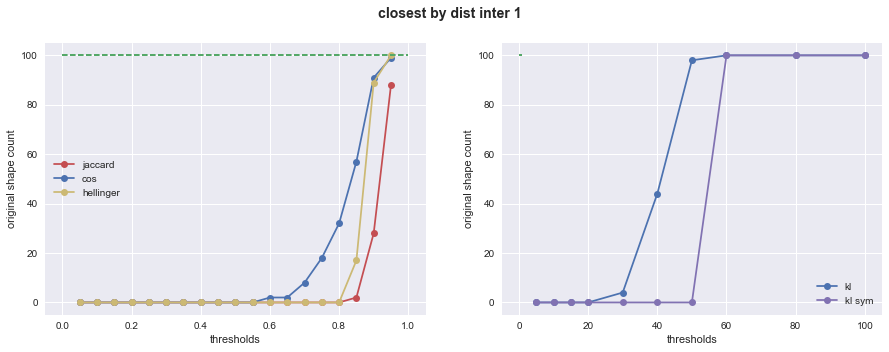

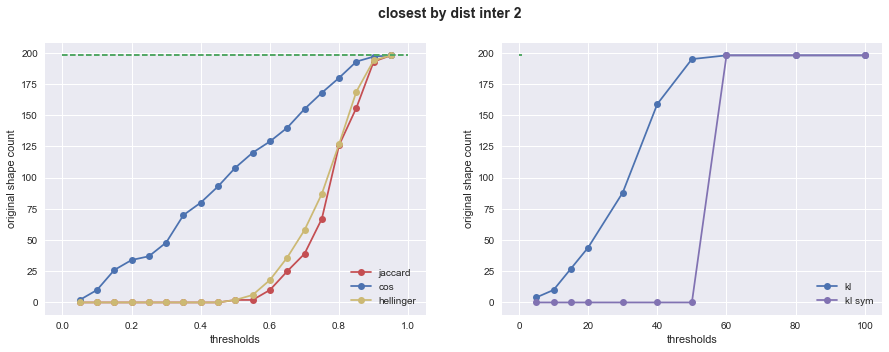

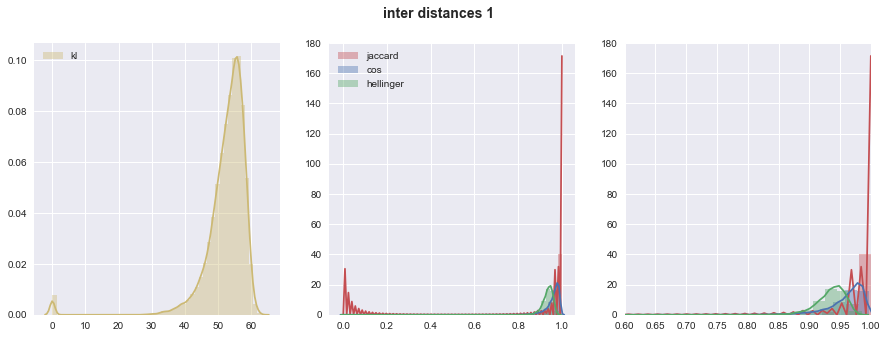

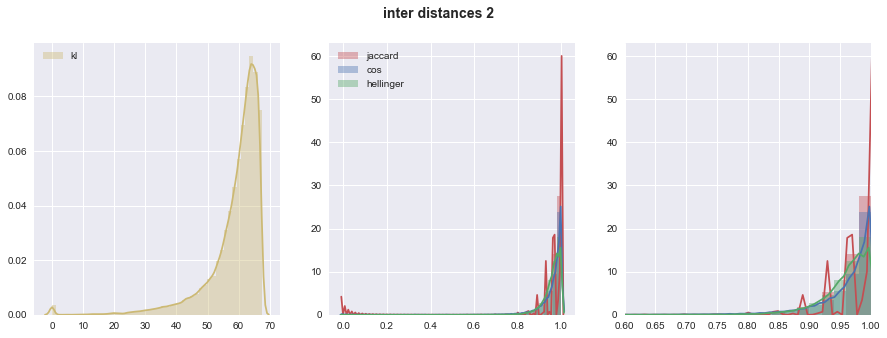

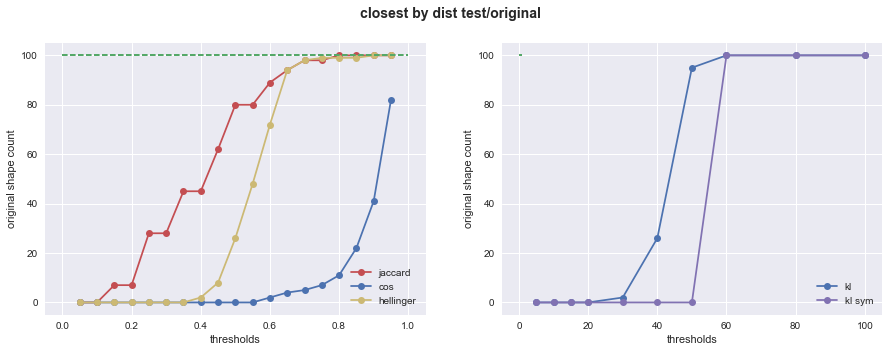

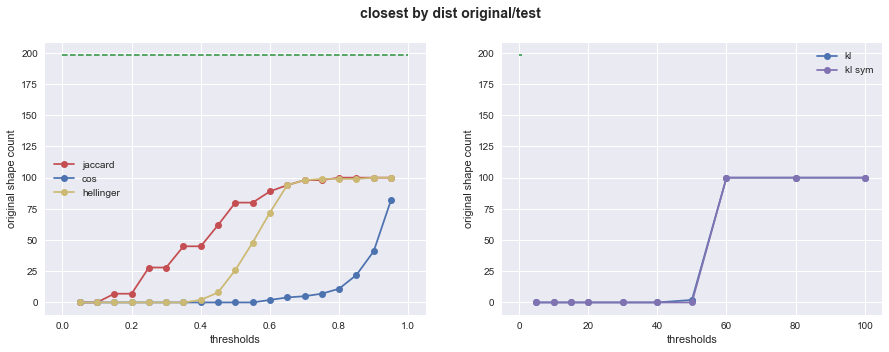

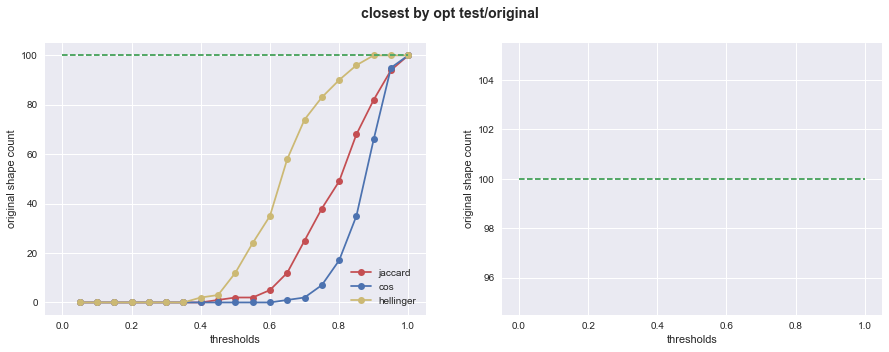

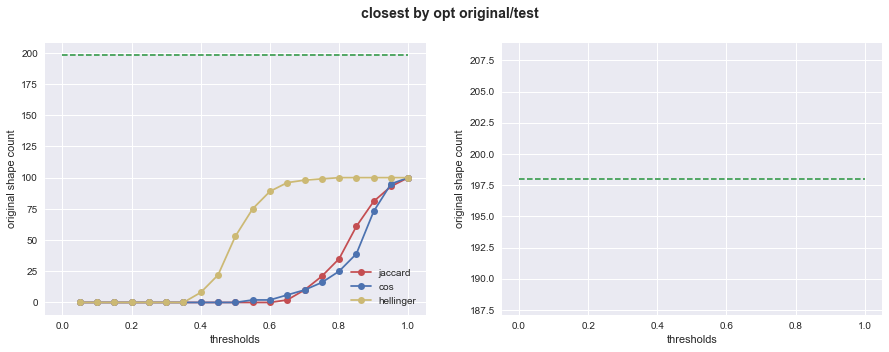

In [22]:
def create_model_rch_300_2(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 3
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 22
names_list[idx] = u'model_rch_300_2'
models_list[idx] = create_model_rch_300_2(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [11]:
idx = 22
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
model_rch_300_2                          -            -            -         -
300 -> 198, 0.99                  24 vs 15  .63 vs 0.36  .78 vs 0.65     -----
closest by dist test/original        j7-h0       j45-h2      j89-h72  j100-h99
closest by dist original/test        j7-h0       j45-h2      j89-h72  j100-h99
closest by opt res test/original       jh0        j0-h2       j5-h35   j49-h90
closest by opt res original/test       jh0        j0-h8       j0-h89  j35-h100

name = model_rch_300_3_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_3_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 199, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_20', u'topic_21', u'topic_22', u'topic_24', u'topic_25', u'topic_26', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u't

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   199.00
non zero ratio                    0.96     0.99
|phi_ij == 0| / n_topics       7689.02  8005.49
|phi_ij > 0.2| / n_topics         0.03     0.32
|phi_ij > 0.1| / n_topics         0.31     1.41
|phi_ij > 0.01| / n_topics       14.64    23.61
|phi_ij > 0.05| / n_topics        1.21     4.82
|phi_ij > 0.001| / n_topics     214.17    42.23
topic_kernel_average_size        23.68    15.31
topic_kernel_average_purity       0.63     0.37
topic_kernel_average_contrast     0.78     0.65

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 199        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_0 not optimized
Column topic_9 not optimized
Column topic_11 not optimized
Column topic_12 not optimized
Column topic_15 not optimized
Column topic_18 not optimized
Column topic_19 not optimized
Column topic_2

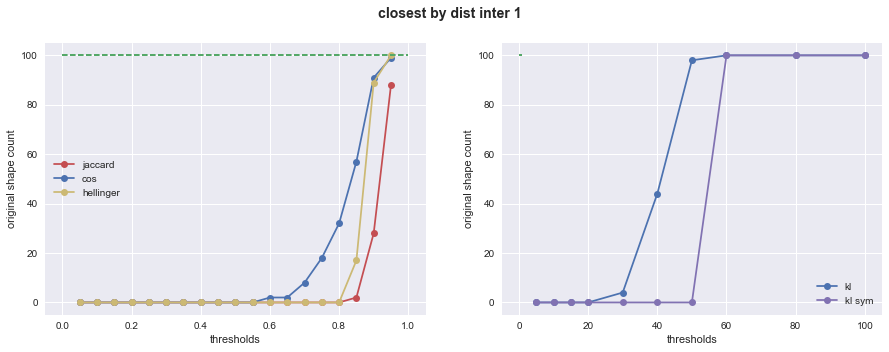

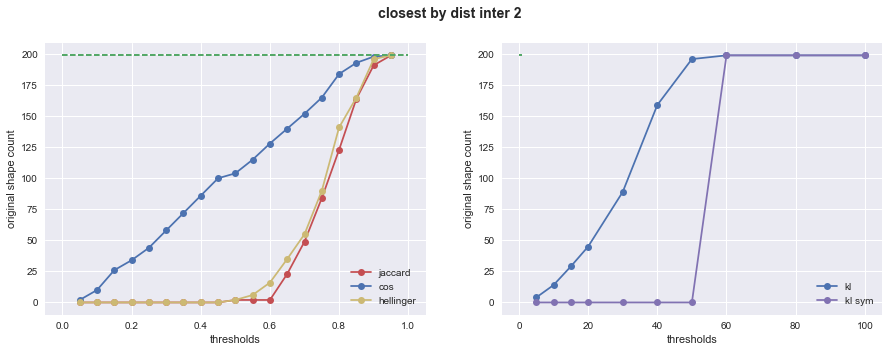

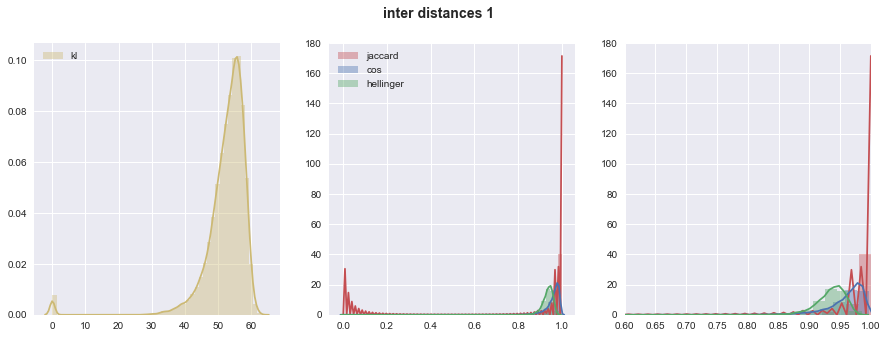

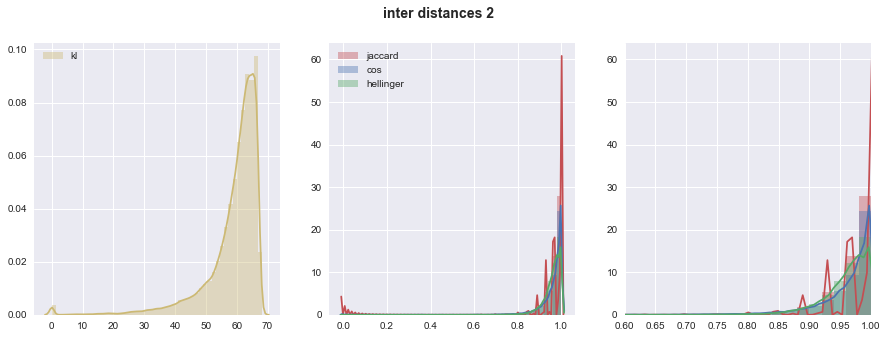

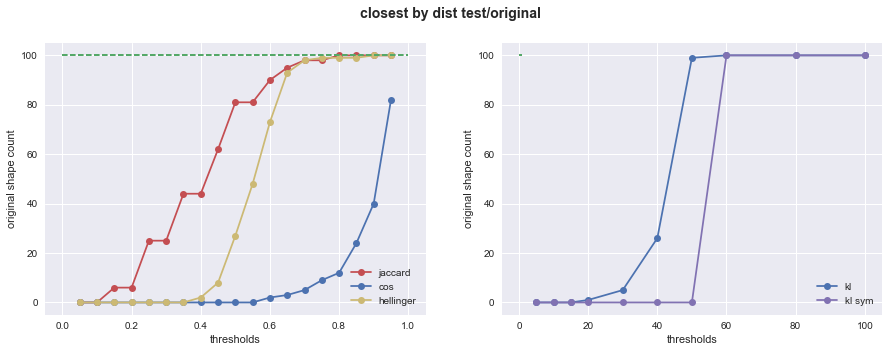

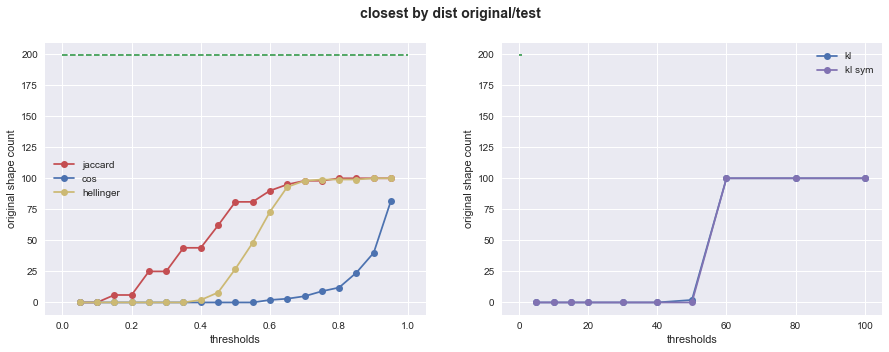

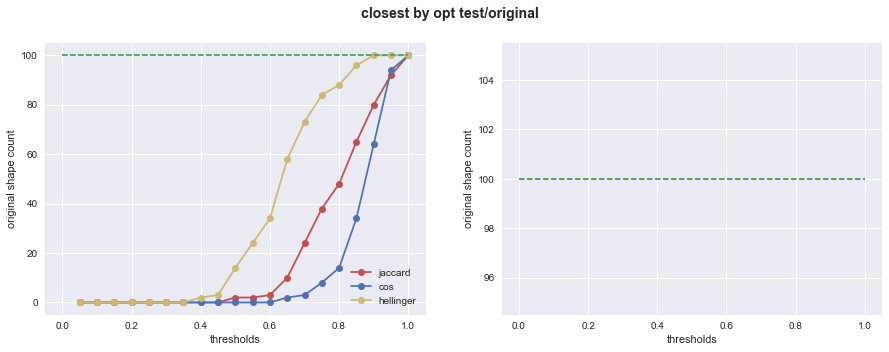

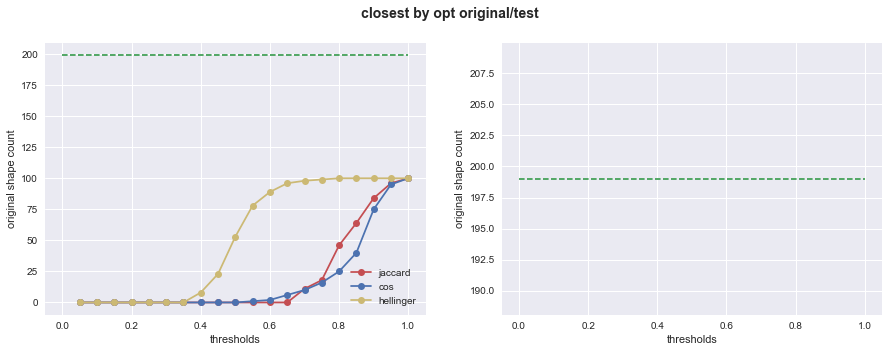

In [23]:
def create_model_rch_300_3(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 23
names_list[idx] = u'model_rch_300_3'
models_list[idx] = create_model_rch_300_3(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [12]:
idx = 23
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
model_rch_300_3                          -            -            -         -
300 -> 199, 0.99                  24 vs 15  .63 vs 0.37  .78 vs 0.65     -----
closest by dist test/original        j6-h0       j44-h2      j90-h73  j100-h99
closest by dist original/test        j6-h0       j44-h2      j90-h73  j100-h99
closest by opt res test/original       jh0        j0-h2       j3-h34   j48-h88
closest by opt res original/test       jh0        j0-h8       j0-h89  j46-h100

name = model_rch_300_4_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 54, [u'topic_6', u'topic_7', u'topic_12', u'topic_13', u'topic_16', u'topic_17', u'topic_20', u'topic_32', u'topic_33', u'topic_35', u'topic_37', u'topic_39', u'topic_43', u'topic_71', u'topic_78', u'topic_84', u'topic_88', u'topic_117', u'topic_126', u'topic_127', u'topic_128', u'topic_129', u'topic_131', u'topic_135', u'topic_140', u'topic_142', u'topic_152', u'topic_156', u'topic_162', u'topic_164', u'topic_168', u'topic_175', u'topic_179', u'topic_197', u'topic_198', u'topic_201', u'topic_202', u'topic_208', u'topic_212', u'topic_213', u'topic_214', u'topic_250', u'topic_252', u'topic_262', u'topic_263', u'topic_264', u'topic_266', u'topic_271', u'topic_274', u'topic_283', u'topic_291', u'topic_292', u'topic_29

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00    54.00
non zero ratio                    0.96     1.00
|phi_ij == 0| / n_topics       7689.02  8011.35
|phi_ij > 0.2| / n_topics         0.03     0.57
|phi_ij > 0.1| / n_topics         0.31     1.96
|phi_ij > 0.01| / n_topics       14.64    19.87
|phi_ij > 0.05| / n_topics        1.21     4.94
|phi_ij > 0.001| / n_topics     214.17    36.20
topic_kernel_average_size        23.68    11.33
topic_kernel_average_purity       0.63     0.56
topic_kernel_average_contrast     0.78     0.68

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 54         Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 54           Column topic_15 not optimized
Column topic_17 not optimized
Column topic_50 not optimized
Column topic_57 not optimized
Column topic_76 not optimized
Column topic_90 not optimized
Dist fn = <function hellinger_dist at 0x000

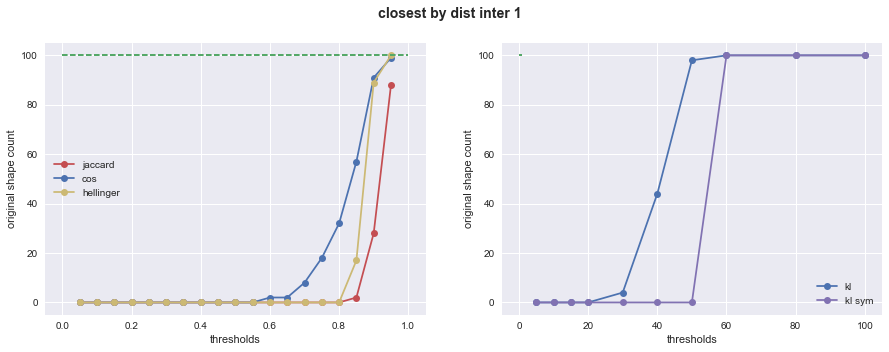

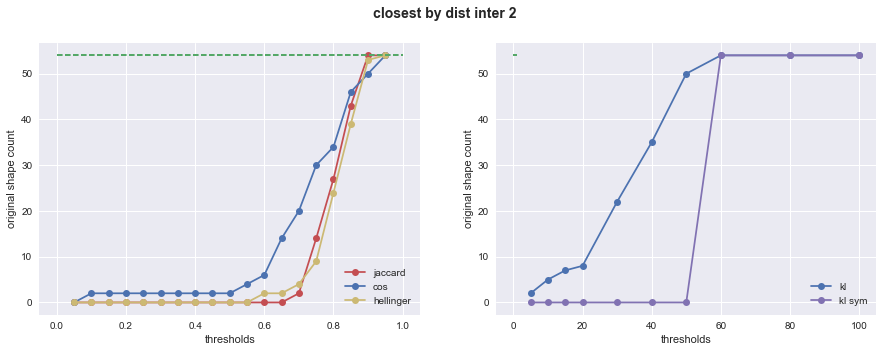

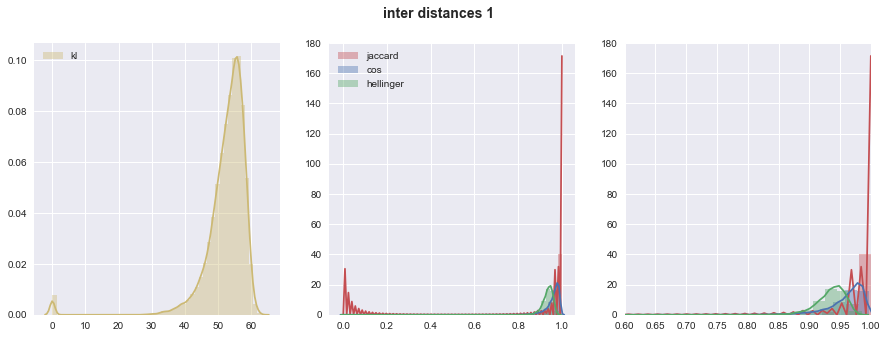

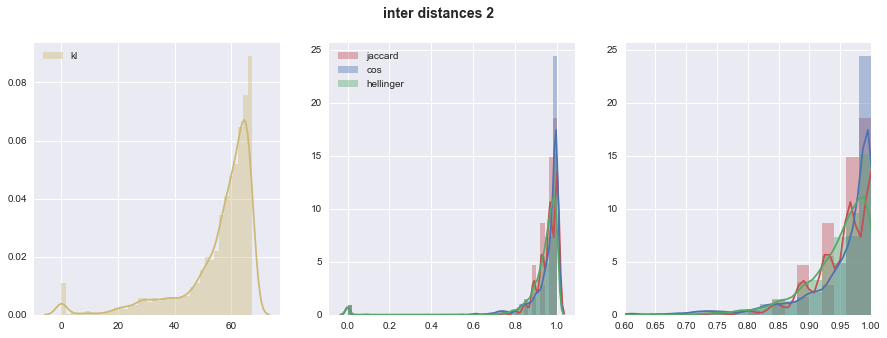

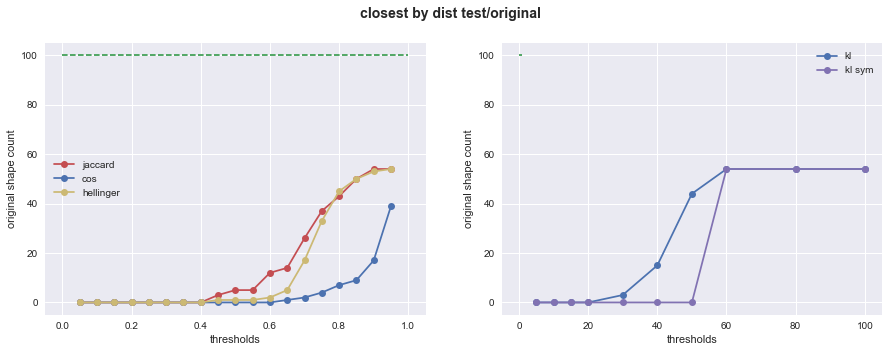

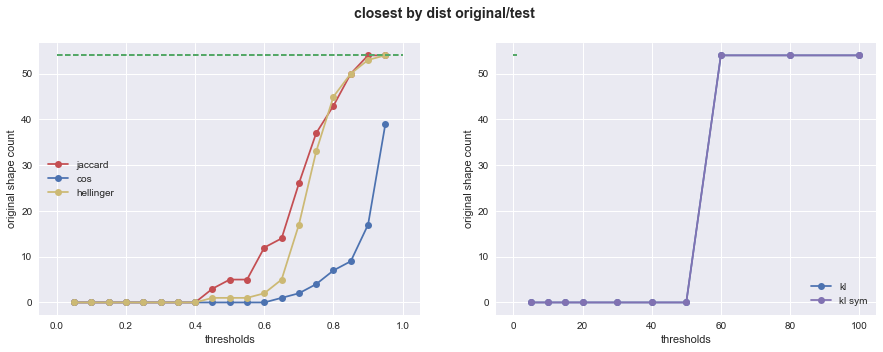

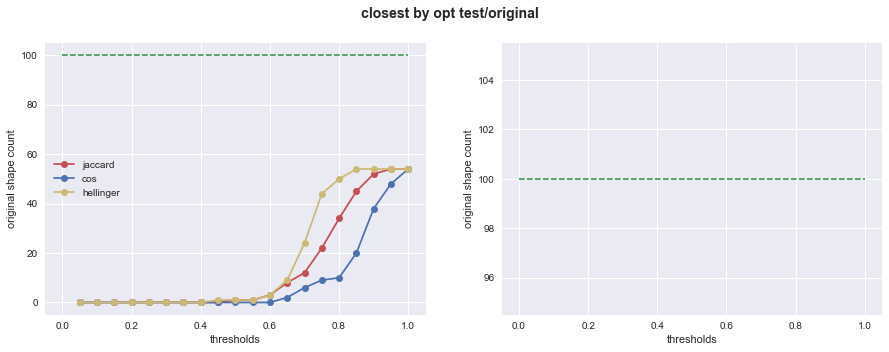

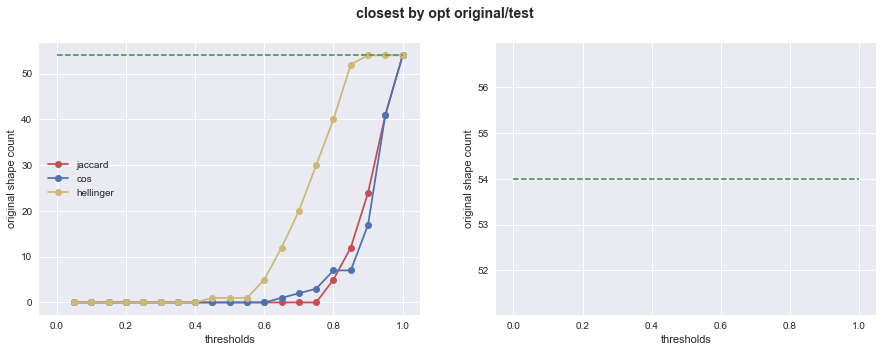

In [24]:
def create_model_rch_300_4(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 24
names_list[idx] = u'model_rch_300_4'
models_list[idx] = create_model_rch_300_4(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [13]:
idx = 24
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
model_rch_300_4                          -            -            -        -
300 -> 54, 1.00                   24 vs 11  .63 vs 0.56  .78 vs 0.68    -----
closest by dist test/original          jh0          jh0       j12-h2  j43-h45
closest by dist original/test          jh0          jh0       j12-h2  j43-h45
closest by opt res test/original       jh0          jh0          jh3  j34-h50
closest by opt res original/test       jh0          jh0        j0-h5   j5-h40

## topic selection only
Без обучения в начале, коэф маленький (0.1)

name = model_rch_300_1_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.1

('Filtered topics: ', 43, [u'topic_6', u'topic_12', u'topic_13', u'topic_28', u'topic_33', u'topic_35', u'topic_39', u'topic_43', u'topic_76', u'topic_78', u'topic_84', u'topic_88', u'topic_117', u'topic_118', u'topic_120', u'topic_126', u'topic_127', u'topic_128', u'topic_138', u'topic_140', u'topic_142', u'topic_152', u'topic_156', u'topic_162', u'topic_164', u'topic_168', u'topic_172', u'topic_188', u'topic_197', u'topic_208', u'topic_212', u'topic_214', u'topic_215', u'topic_235', u'topic_244', u'topic_250', u'topic_262', u'topic_264', u'topic_266', u'topic_274', u'topic_283', u'topic_291', u'topic_292'])

------------------------------------------------------------ phi -----------------------------------------------------

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00    43.00
non zero ratio                    0.96     0.99
|phi_ij == 0| / n_topics       7689.02  8007.21
|phi_ij > 0.2| / n_topics         0.03     0.81
|phi_ij > 0.1| / n_topics         0.31     1.98
|phi_ij > 0.01| / n_topics       14.64    18.98
|phi_ij > 0.05| / n_topics        1.21     4.47
|phi_ij > 0.001| / n_topics     214.17    39.02
topic_kernel_average_size        23.68    14.81
topic_kernel_average_purity       0.63     0.62
topic_kernel_average_contrast     0.78     0.68

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 43         Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 43           Column topic_90 not optimized
Dist fn = <function hellinger_dist at 0x000000000BF32B38>, Processed th = 1.0, original columns count = 43     [(u'topic_6', u'topic_24', 0, 24, 0.65866694398277192), (u'topic_12', u'topic_3', 

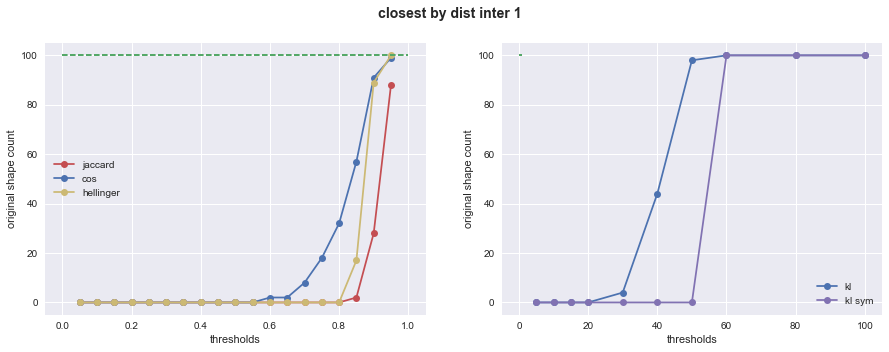

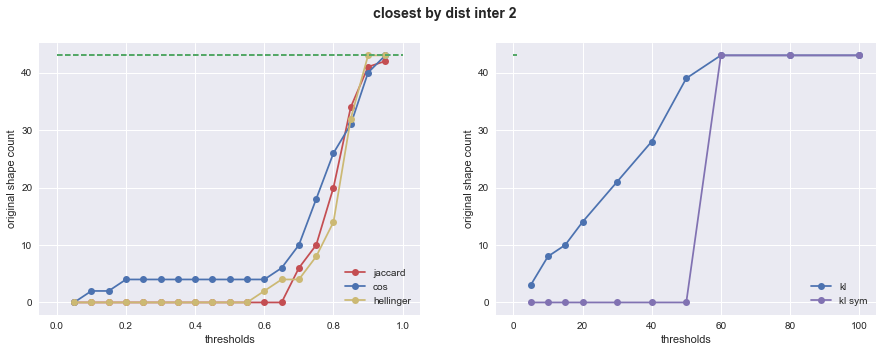

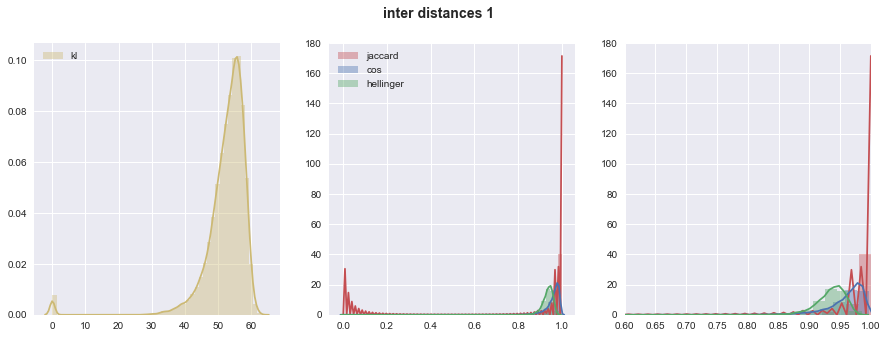

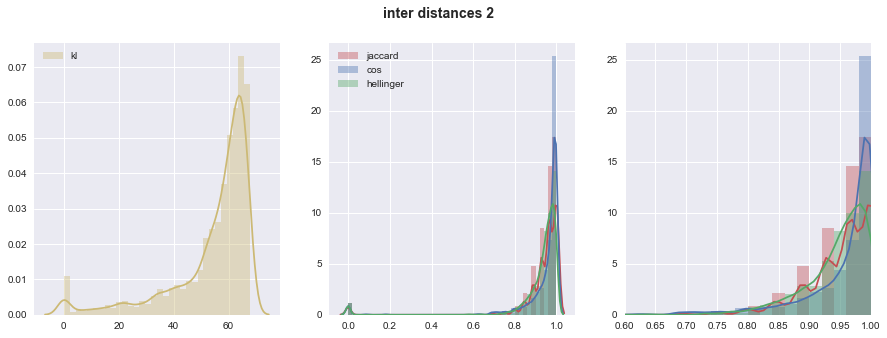

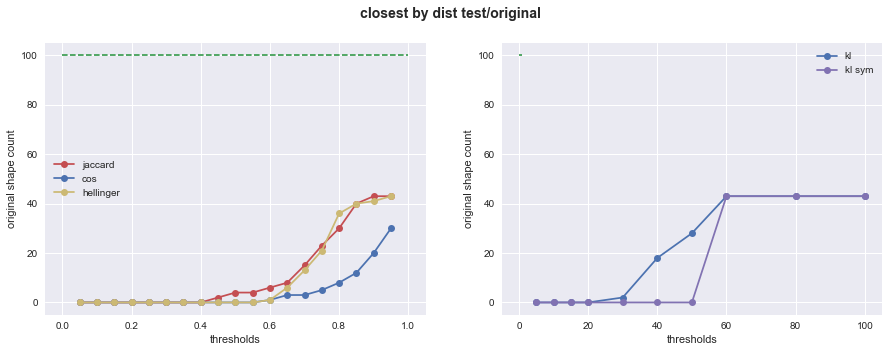

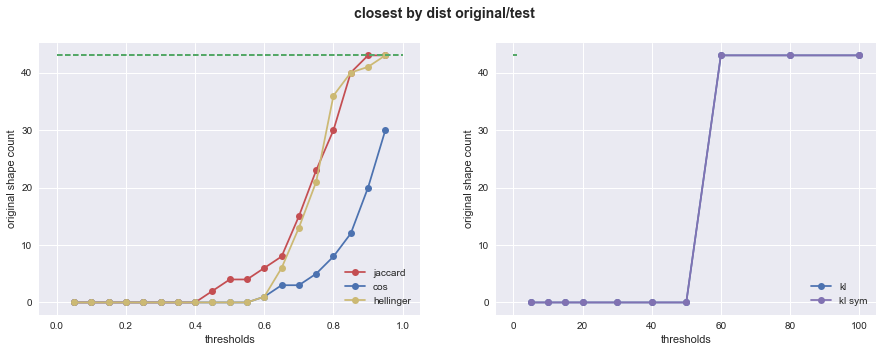

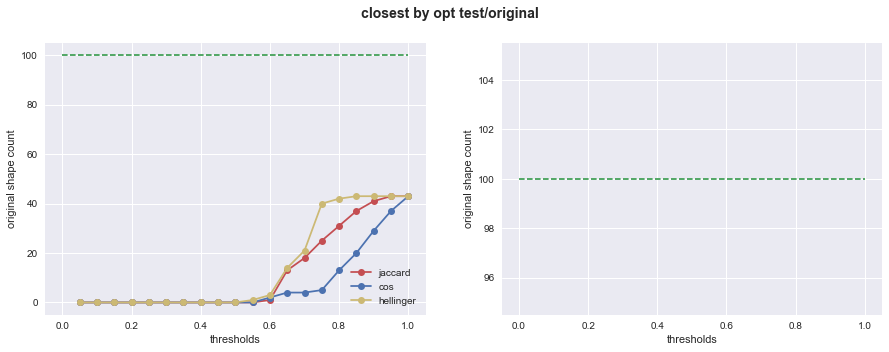

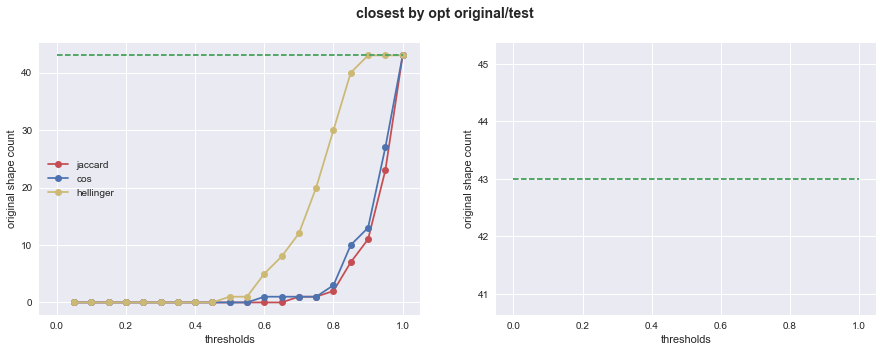

In [25]:
def create_model_rch_300_1_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.1
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 31
names_list[idx] = u'model_rch_300_1_ts'
models_list[idx] = create_model_rch_300_1_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [14]:
idx = 31
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
model_rch_300_1_ts                       -            -            -        -
300 -> 43, 0.99                   24 vs 15  .63 vs 0.62  .78 vs 0.68    --+--
closest by dist test/original          jh0          jh0        j6-h1  j30-h36
closest by dist original/test          jh0          jh0        j6-h1  j30-h36
closest by opt res test/original       jh0          jh0        j1-h3  j31-h42
closest by opt res original/test       jh0          jh0        j0-h5   j2-h30

name = model_rch_300_2_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_2_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 175, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_20', u'topic_22', u'topic_24', u'topic_26', u'topic_28', u'topic_29', u'topic_30', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_52', u'topic_55', u'topic_56', u'topic_59', u'topic_60', u'topic_62', u't

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   175.00
non zero ratio                    0.96     0.99
|phi_ij == 0| / n_topics       7689.02  7993.80
|phi_ij > 0.2| / n_topics         0.03     0.30
|phi_ij > 0.1| / n_topics         0.31     1.27
|phi_ij > 0.01| / n_topics       14.64    25.54
|phi_ij > 0.05| / n_topics        1.21     4.03
|phi_ij > 0.001| / n_topics     214.17    52.39
topic_kernel_average_size        23.68    17.23
topic_kernel_average_purity       0.63     0.35
topic_kernel_average_contrast     0.78     0.68

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 175        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_115 not optimized
Column topic_143 not optimized
Column topic_152 not optimized
Column topic_283 not optimized
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 

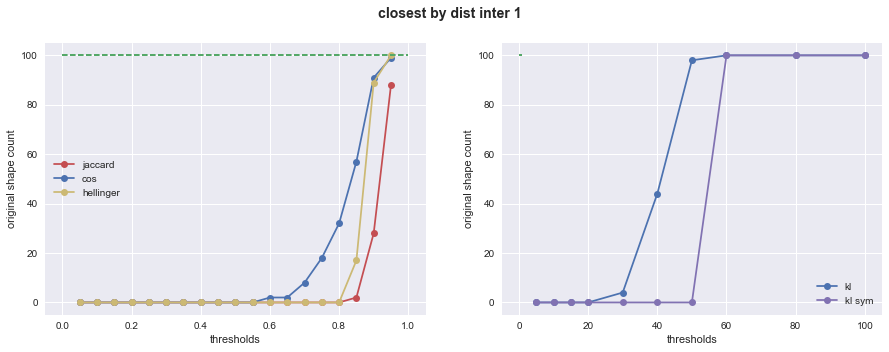

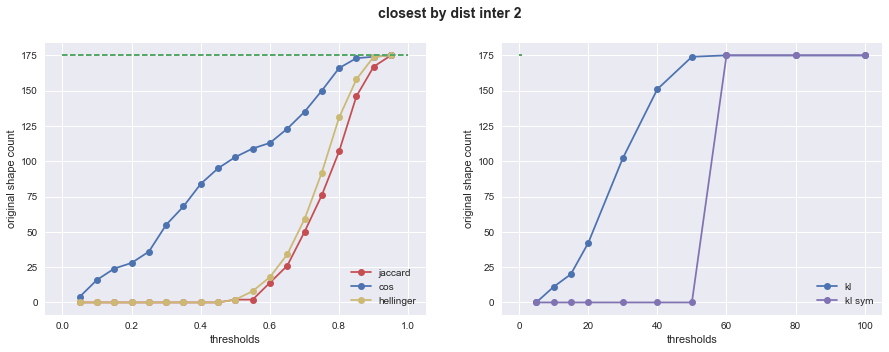

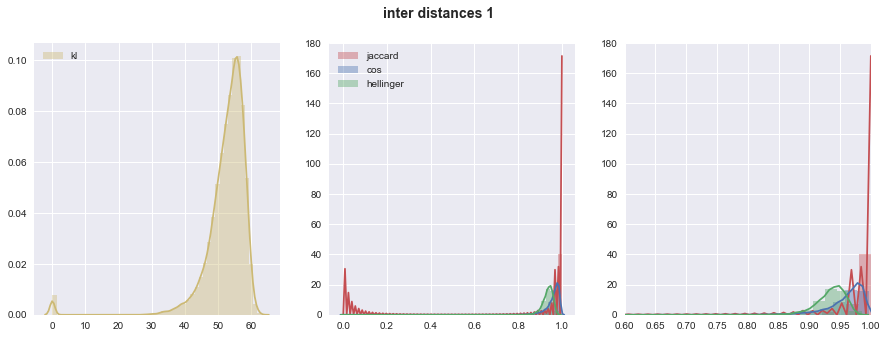

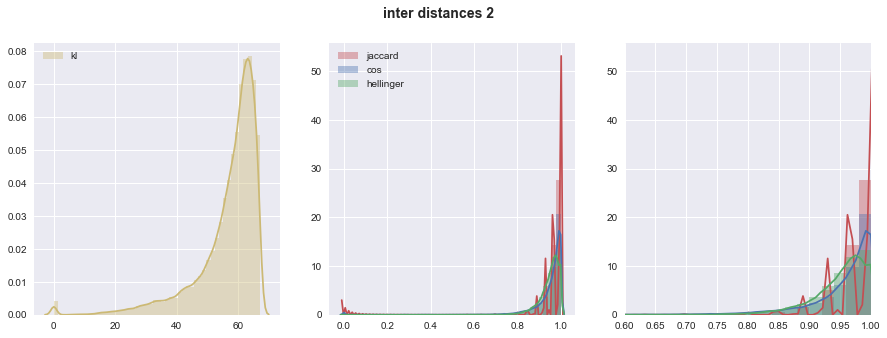

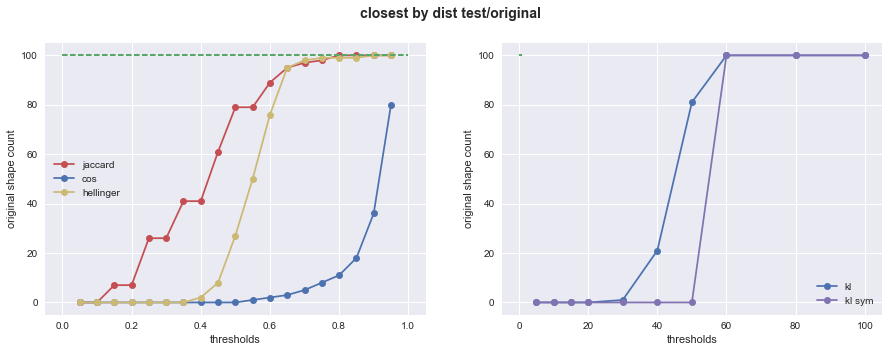

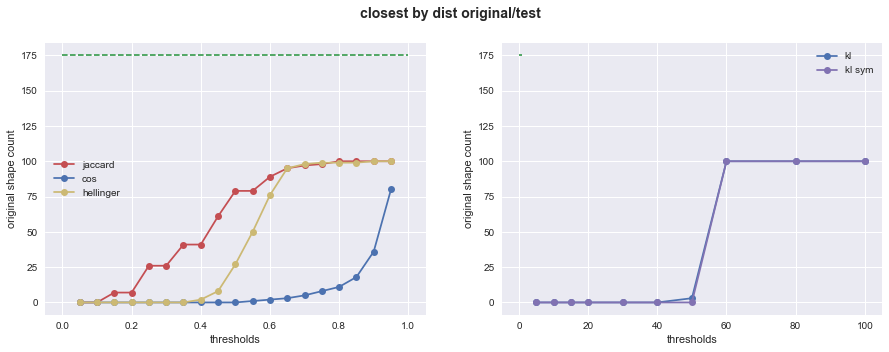

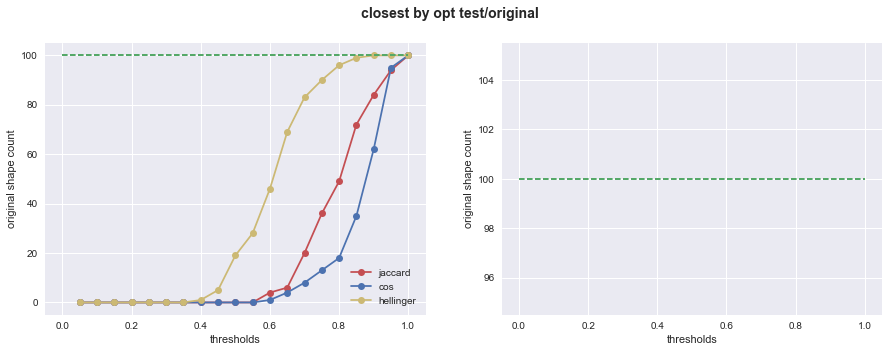

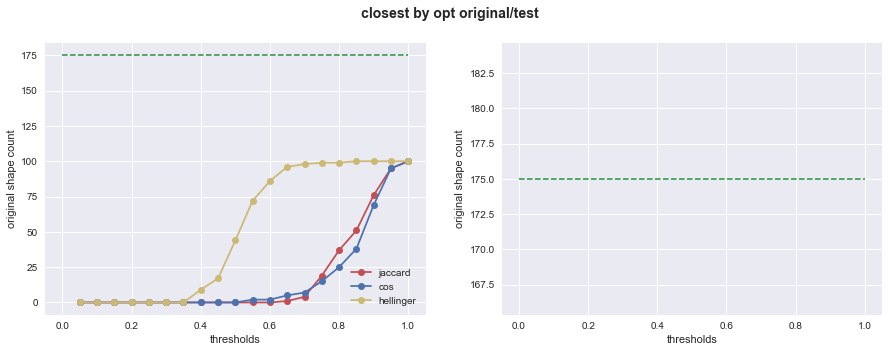

In [26]:
def create_model_rch_300_2_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 32
names_list[idx] = u'model_rch_300_2_ts'
models_list[idx] = create_model_rch_300_2_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [15]:
idx = 32
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
model_rch_300_2_ts                       -            -            -         -
300 -> 175, 0.99                  24 vs 17  .63 vs 0.35  .78 vs 0.68     -----
closest by dist test/original        j7-h0       j41-h2      j89-h76  j100-h99
closest by dist original/test        j7-h0       j41-h2      j89-h76  j100-h99
closest by opt res test/original       jh0        j0-h1       j4-h46   j49-h96
closest by opt res original/test       jh0        j0-h9       j0-h86   j37-h99

name = model_rch_300_3_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_3_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
ss_phi_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 154, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_18', u'topic_20', u'topic_22', u'topic_24', u'topic_28', u'topic_29', u'topic_30', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_37', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_55', u'topic_56', u'topic_59', u'topic_60', u'topic_62', u'topic_63', u'topic_66', u'topic

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   154.00
non zero ratio                    0.96     0.99
|phi_ij == 0| / n_topics       7689.02  7995.84
|phi_ij > 0.2| / n_topics         0.03     0.29
|phi_ij > 0.1| / n_topics         0.31     1.29
|phi_ij > 0.01| / n_topics       14.64    25.24
|phi_ij > 0.05| / n_topics        1.21     4.23
|phi_ij > 0.001| / n_topics     214.17    51.18
topic_kernel_average_size        23.68    16.84
topic_kernel_average_purity       0.63     0.39
topic_kernel_average_contrast     0.78     0.71

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 154        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_9 not optimized
Column topic_48 not optimized
Column topic_88 not optimized
Column topic_209 not optimized
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100 

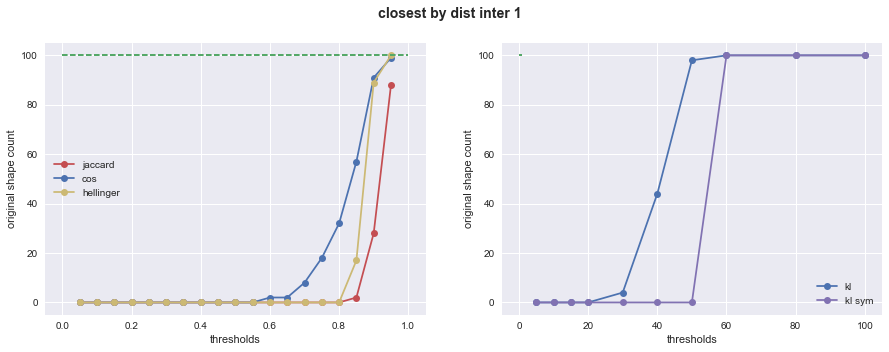

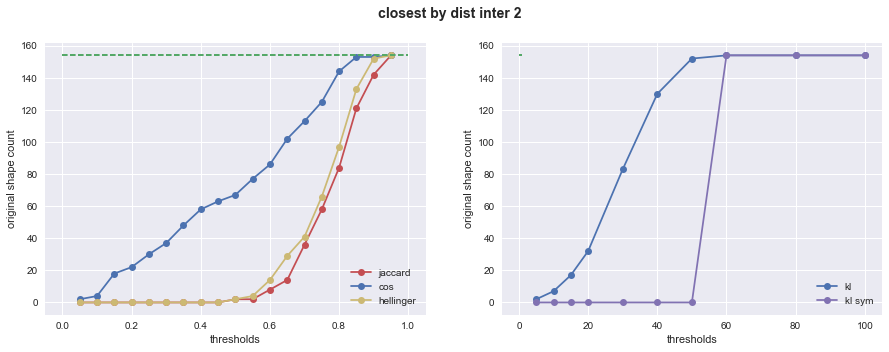

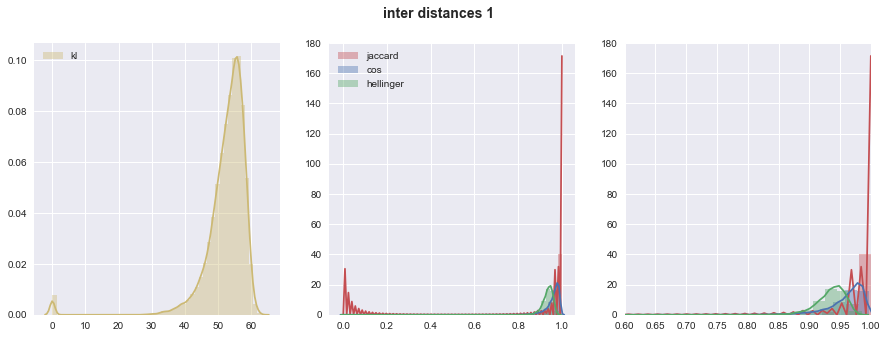

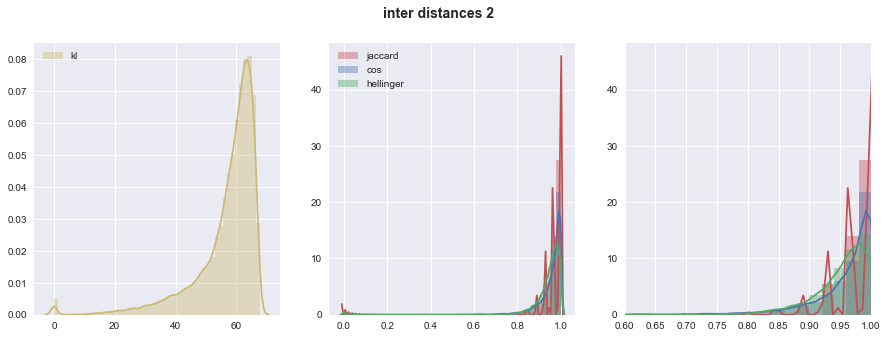

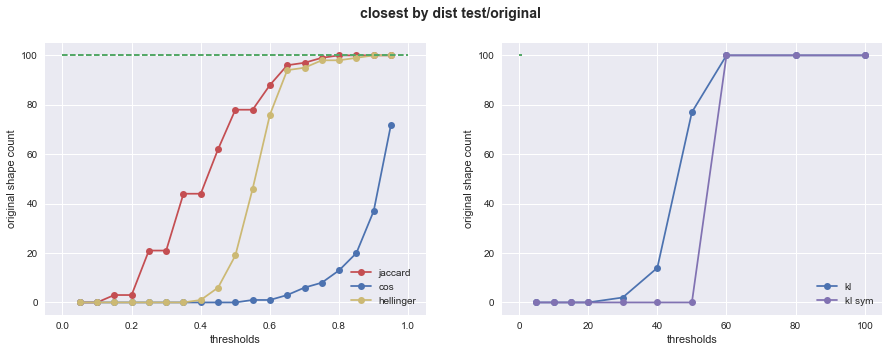

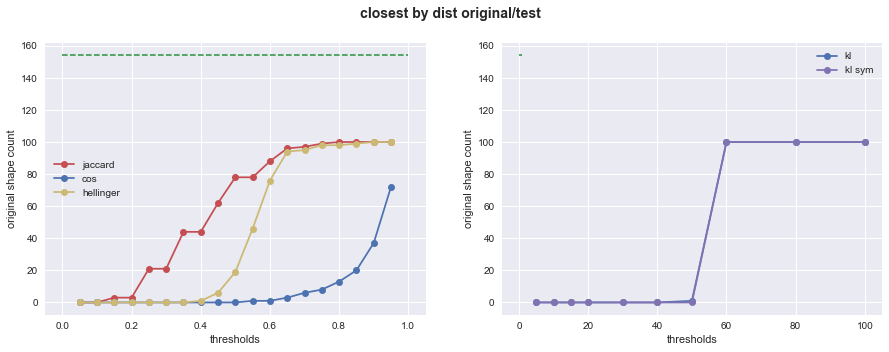

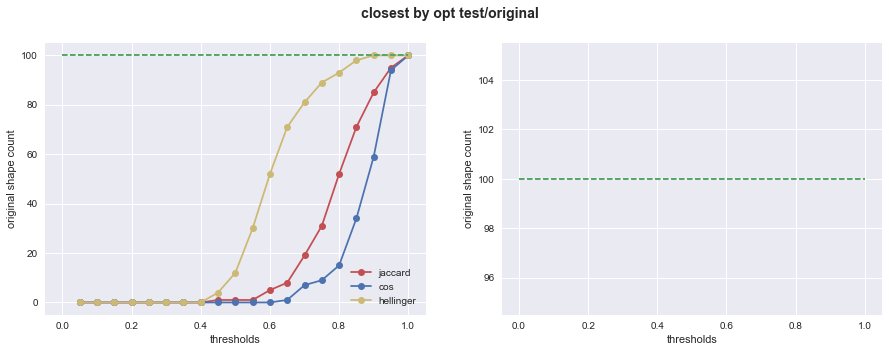

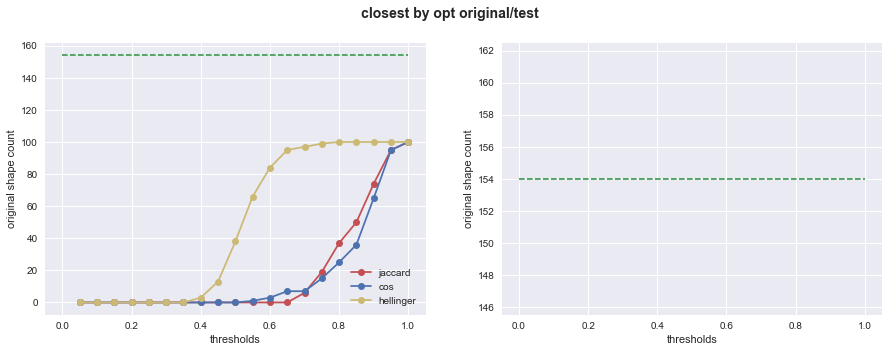

In [27]:
def create_model_rch_300_3_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 33
names_list[idx] = u'model_rch_300_3_ts'
models_list[idx] = create_model_rch_300_3_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [16]:
idx = 33
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
model_rch_300_3_ts                       -            -            -         -
300 -> 154, 0.99                  24 vs 17  .63 vs 0.39  .78 vs 0.71     -----
closest by dist test/original        j3-h0       j44-h1      j88-h76  j100-h98
closest by dist original/test        j3-h0       j44-h1      j88-h76  j100-h98
closest by opt res test/original       jh0          jh0       j5-h52   j52-h93
closest by opt res original/test       jh0        j0-h3       j0-h84  j37-h100

name = model_rch_300_4_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_300_4_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
ss_phi_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.7

('Filtered topics: ', 139, [u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_22', u'topic_24', u'topic_28', u'topic_29', u'topic_30', u'topic_32', u'topic_33', u'topic_34', u'topic_37', u'topic_41', u'topic_42', u'topic_43', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_52', u'topic_55', u'topic_56', u'topic_59', u'topic_60', u'topic_62', u'topic_63', u'topic_66', u'topic_68', u'topic_69', u'topic_71', u'topic_74', u'topic_77', u'topic_80', u'topi

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   139.00
non zero ratio                    0.96     0.99
|phi_ij == 0| / n_topics       7689.02  7989.83
|phi_ij > 0.2| / n_topics         0.03     0.31
|phi_ij > 0.1| / n_topics         0.31     1.21
|phi_ij > 0.01| / n_topics       14.64    26.44
|phi_ij > 0.05| / n_topics        1.21     3.60
|phi_ij > 0.001| / n_topics     214.17    56.45
topic_kernel_average_size        23.68    18.76
topic_kernel_average_purity       0.63     0.44
topic_kernel_average_contrast     0.78     0.75

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 139        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_9 not optimized
Column topic_29 not optimized
Column topic_88 not optimized
Column topic_143 not optimized
Column topic_158 not optimized
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0

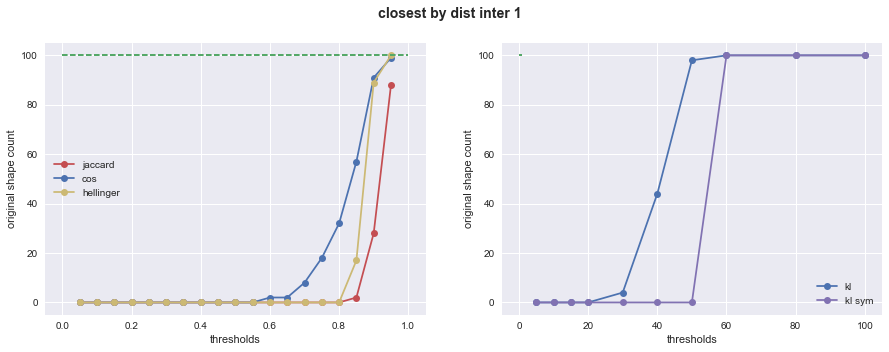

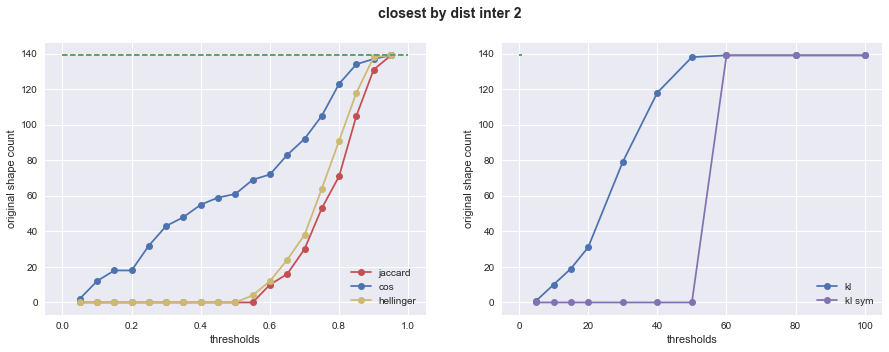

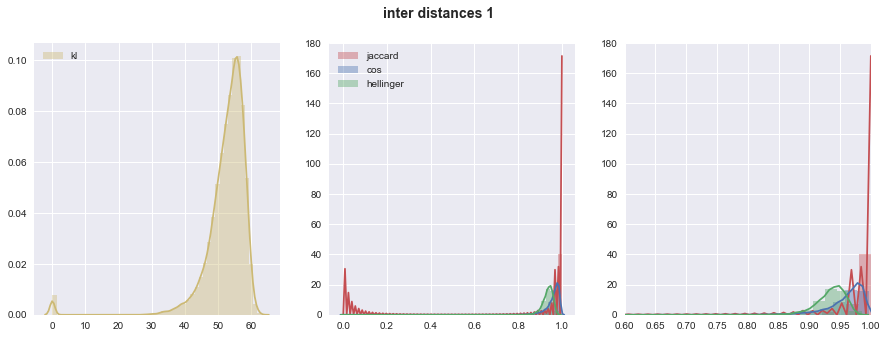

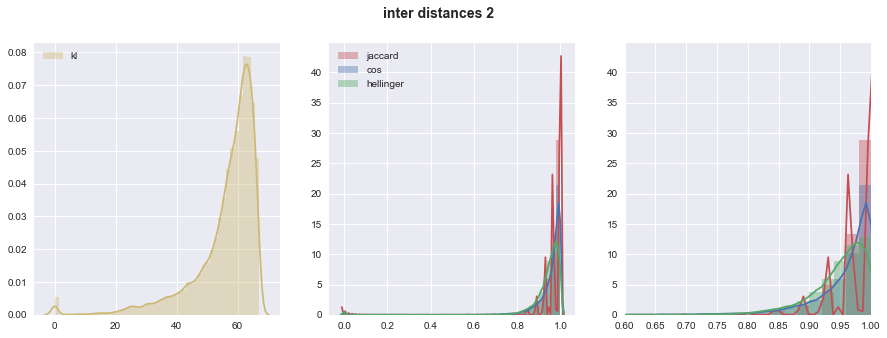

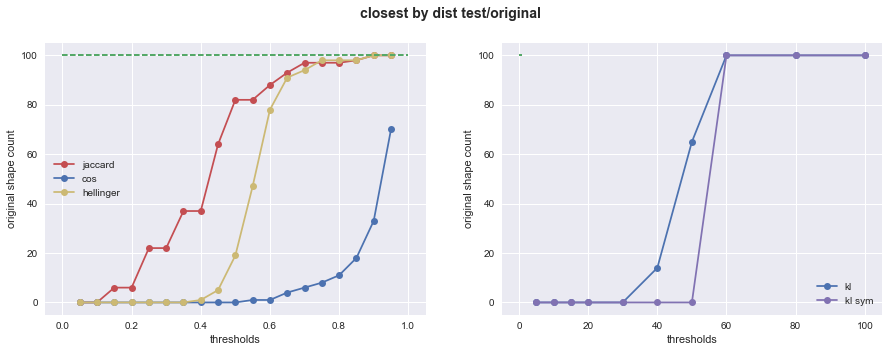

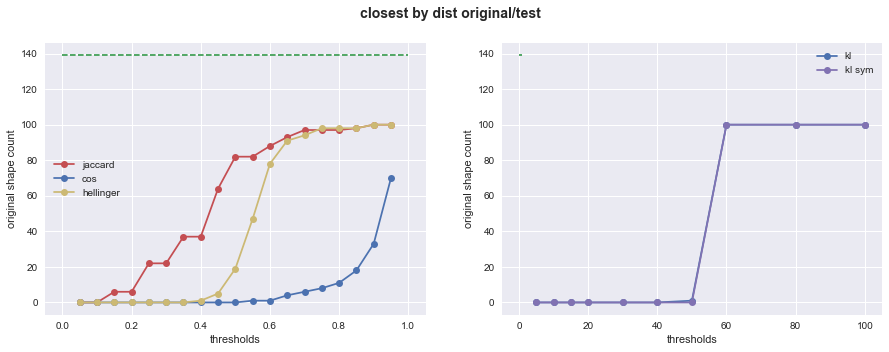

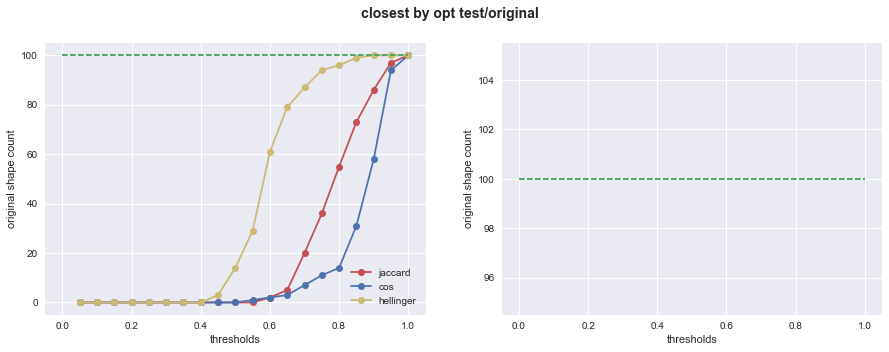

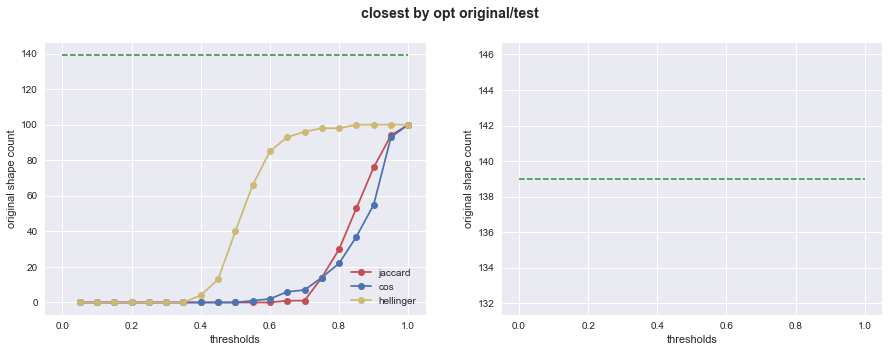

In [28]:
def create_model_rch_300_4_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 34
names_list[idx] = u'model_rch_300_4_ts'
models_list[idx] = create_model_rch_300_4_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [17]:
idx = 34
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
model_rch_300_4_ts                       -            -            -        -
300 -> 139, 0.99                  24 vs 19  .63 vs 0.44  .78 vs 0.75    -----
closest by dist test/original        j6-h0       j37-h1      j88-h78  j97-h98
closest by dist original/test        j6-h0       j37-h1      j88-h78  j97-h98
closest by opt res test/original       jh0          jh0       j2-h61  j55-h96
closest by opt res original/test       jh0        j0-h4       j0-h85  j30-h98

name = model_rch_300_5_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 214, [u'topic_0', u'topic_1', u'topic_3', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_19', u'topic_22', u'topic_23', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_41', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_52', u'topic_53', u'topic_55', u'topic_56', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_65', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_72', u'topic_73', u'topic_75', u'topic_76', u'topic_77', u'topic_78', u'topic_80', u'topi

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   214.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       7689.02  7770.50
|phi_ij > 0.2| / n_topics         0.03     0.52
|phi_ij > 0.1| / n_topics         0.31     1.40
|phi_ij > 0.01| / n_topics       14.64    20.58
|phi_ij > 0.05| / n_topics        1.21     3.59
|phi_ij > 0.001| / n_topics     214.17    67.76
topic_kernel_average_size        23.68    22.21
topic_kernel_average_purity       0.63     0.51
topic_kernel_average_contrast     0.78     0.68

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 214        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_2 not optimized
Column topic_5 not optimized
Column topic_9 not optimized
Column topic_12 not optimized
Column topic_14 not optimized
Column topic_21 not optimized
Column topic_23 

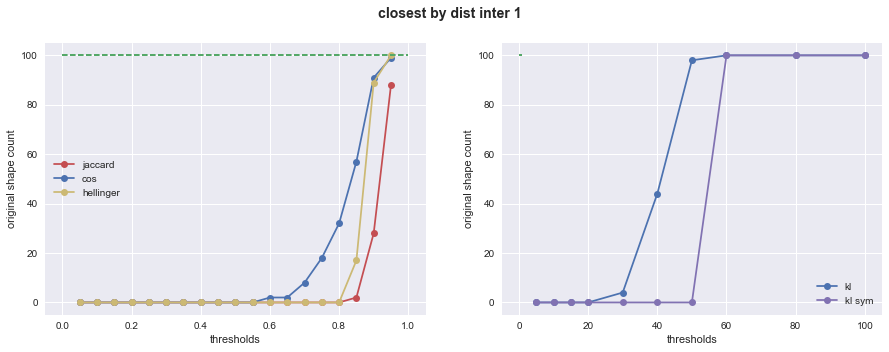

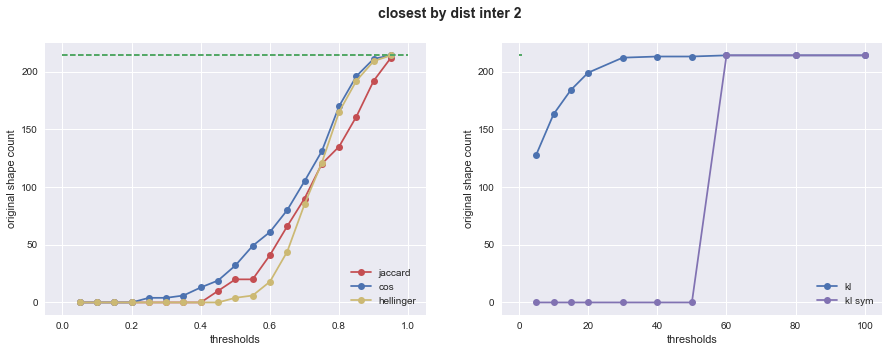

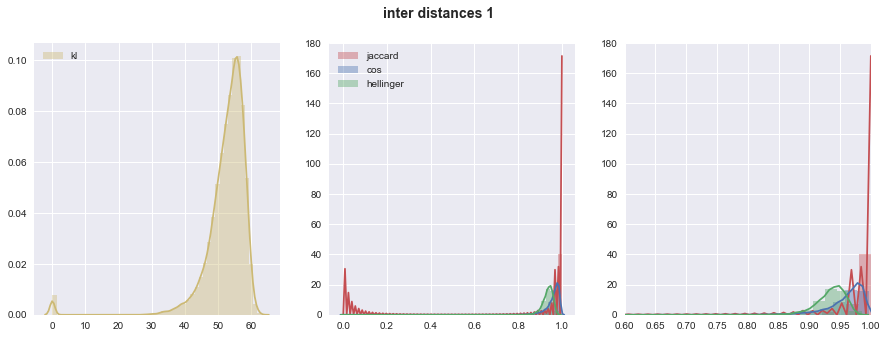

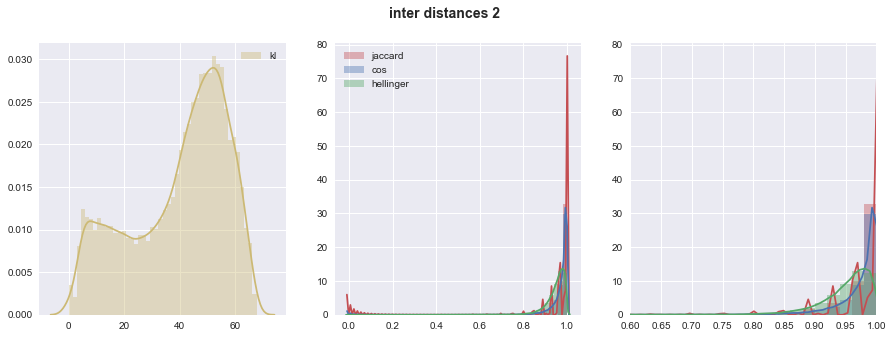

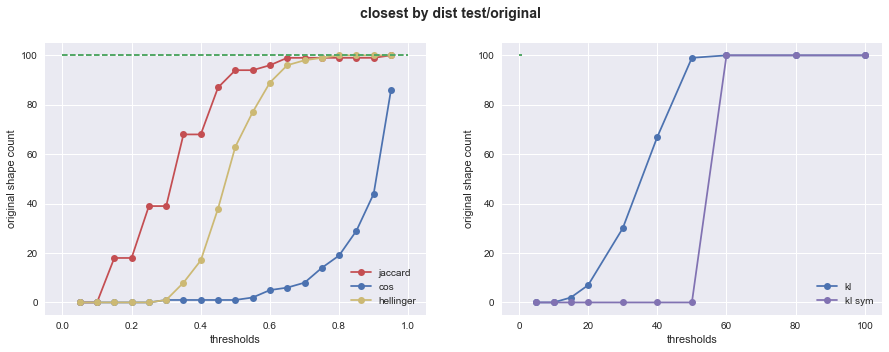

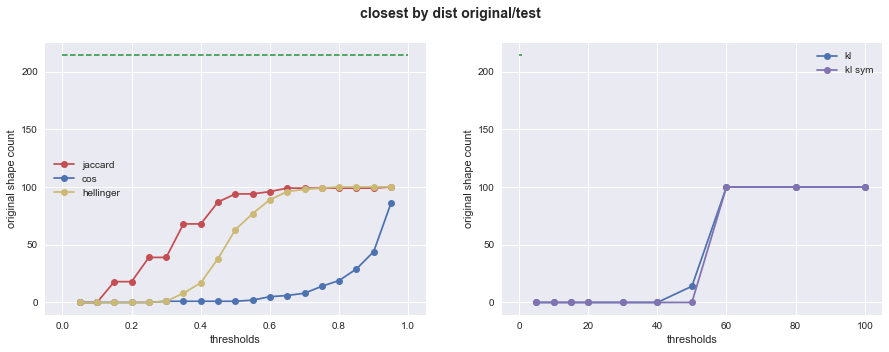

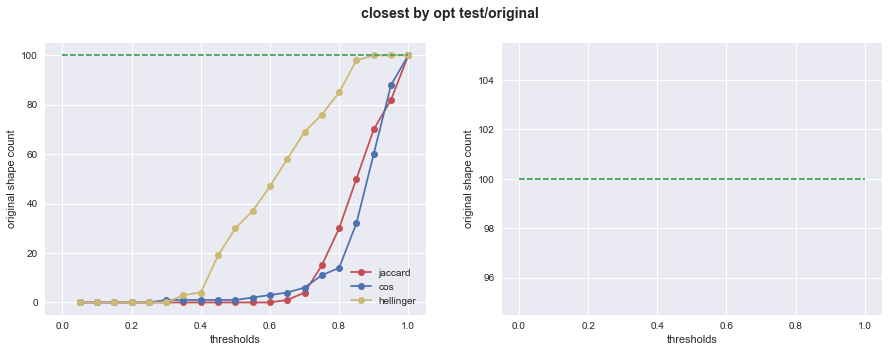

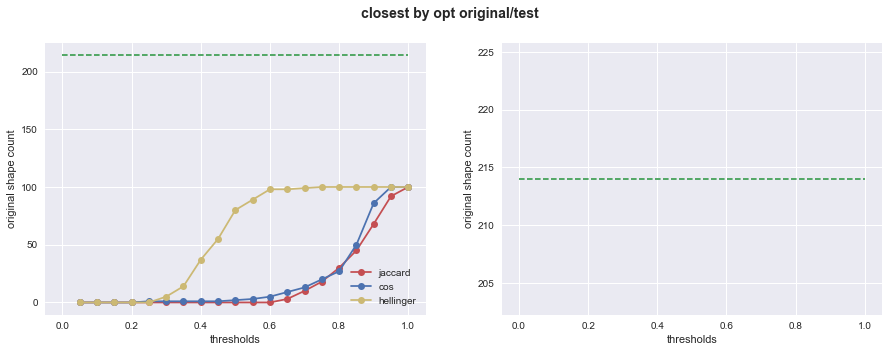

In [29]:
def create_model_rch_300_5_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    return tmp_model

idx = 35
names_list[idx] = u'model_rch_300_5_ts'
models_list[idx] = create_model_rch_300_5_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [18]:
idx = 35
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
model_rch_300_5_ts                       -            -            -         -
300 -> 214, 0.97                  24 vs 22  .63 vs 0.51  .78 vs 0.68     -----
closest by dist test/original       j18-h0      j68-h17      j96-h89  j99-h100
closest by dist original/test       j18-h0      j68-h17      j96-h89  j99-h100
closest by opt res test/original       jh0        j0-h4       j0-h47   j30-h85
closest by opt res original/test       jh0       j0-h37       j0-h98  j30-h100

## decorrelator + topic selection

name = create_model_rch_300_1_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_300_1_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_300_1_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 179, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_20', u'topic_21'

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   179.00
non zero ratio                    0.96     1.00
|phi_ij == 0| / n_topics       7689.02  8012.17
|phi_ij > 0.2| / n_topics         0.03     0.33
|phi_ij > 0.1| / n_topics         0.31     1.41
|phi_ij > 0.01| / n_topics       14.64    23.27
|phi_ij > 0.05| / n_topics        1.21     5.10
|phi_ij > 0.001| / n_topics     214.17    38.16
topic_kernel_average_size        23.68    14.85
topic_kernel_average_purity       0.63     0.47
topic_kernel_average_contrast     0.78     0.71

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 179        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_2 not optimized
Column topic_5 not optimized
Column topic_10 not optimized
Column topic_11 not optimized
Column topic_16 not optimized
Column topic_20 not optimized
Column topic_29 not optimized
Column topic_3

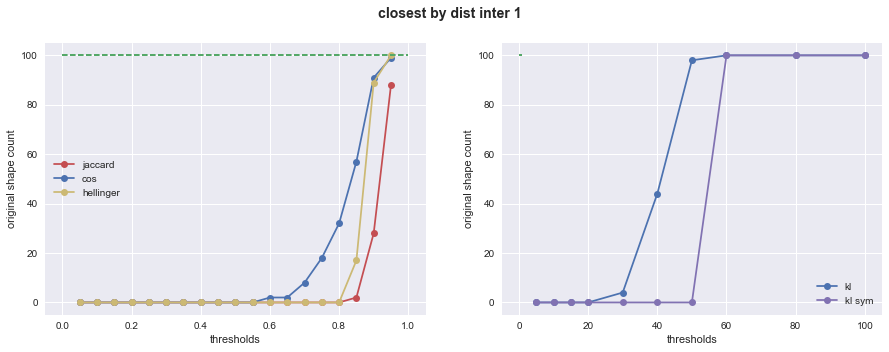

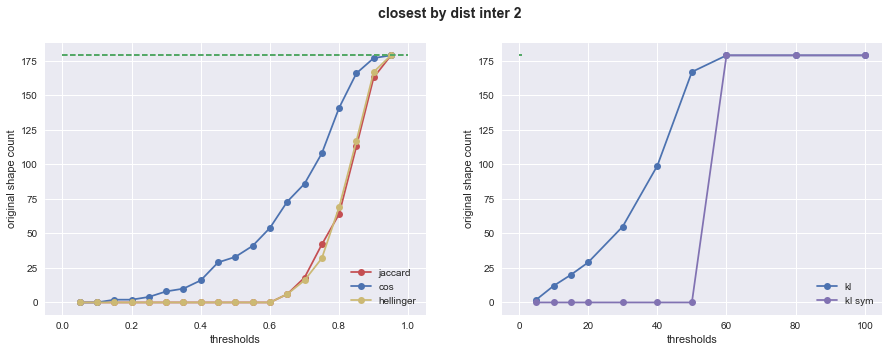

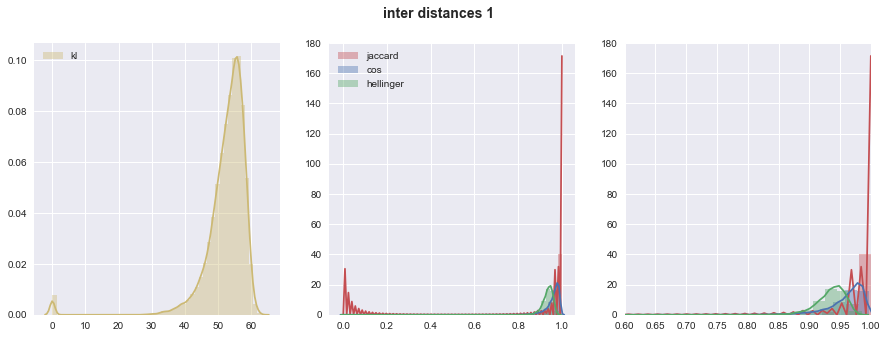

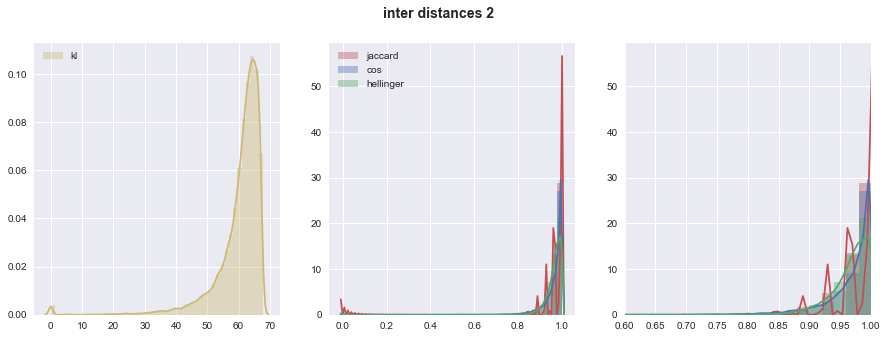

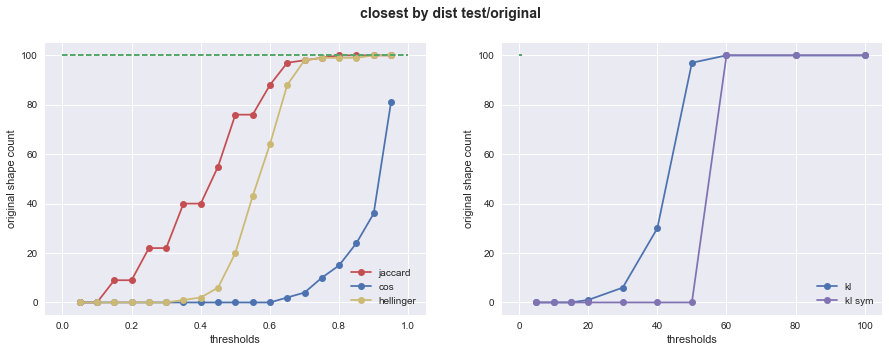

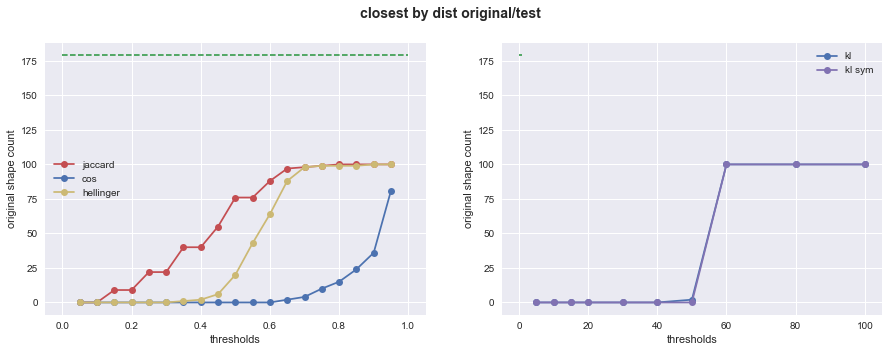

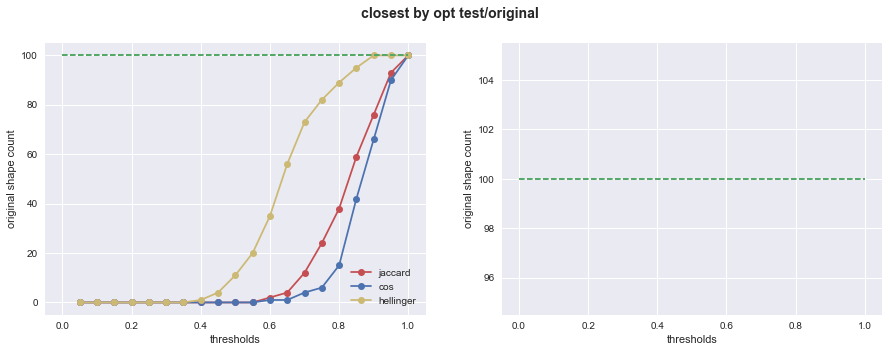

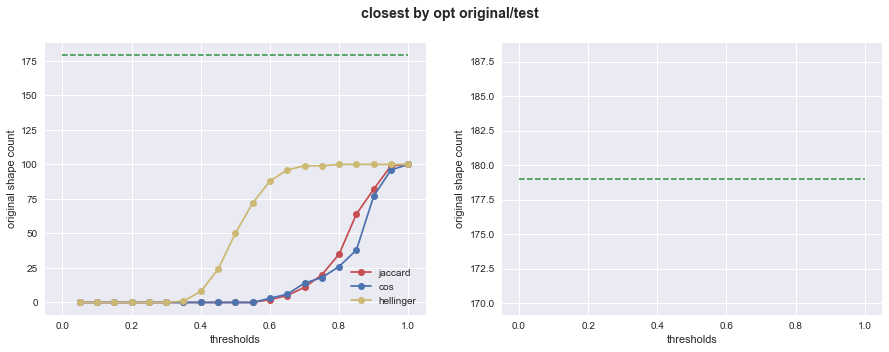

In [30]:
def create_model_rch_300_1_decor_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_300_1_decor_ts'
models_list[idx] = create_model_rch_300_1_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

name = create_model_rch_300_2_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_300_2_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_300_2_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 170, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_20', u'topic_21'

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   170.00
non zero ratio                    0.96     1.00
|phi_ij == 0| / n_topics       7689.02  8011.73
|phi_ij > 0.2| / n_topics         0.03     0.35
|phi_ij > 0.1| / n_topics         0.31     1.37
|phi_ij > 0.01| / n_topics       14.64    23.41
|phi_ij > 0.05| / n_topics        1.21     4.98
|phi_ij > 0.001| / n_topics     214.17    38.65
topic_kernel_average_size        23.68    15.52
topic_kernel_average_purity       0.63     0.48
topic_kernel_average_contrast     0.78     0.73

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 170        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_2 not optimized
Column topic_5 not optimized
Column topic_7 not optimized
Column topic_8 not optimized
Column topic_11 not optimized
Column topic_17 not optimized
Column topic_26 not optimized
Column topic_27 

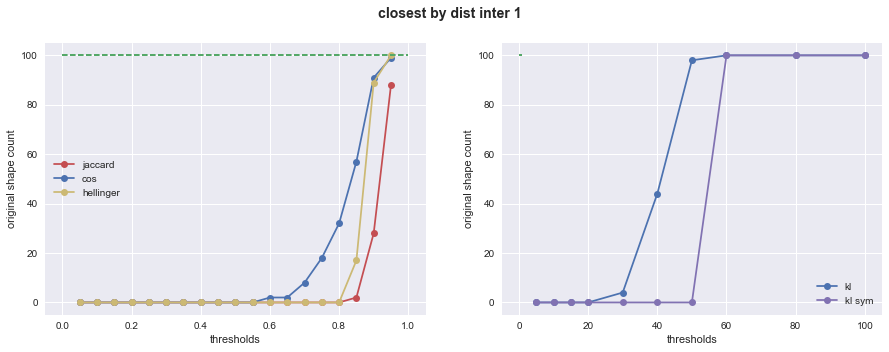

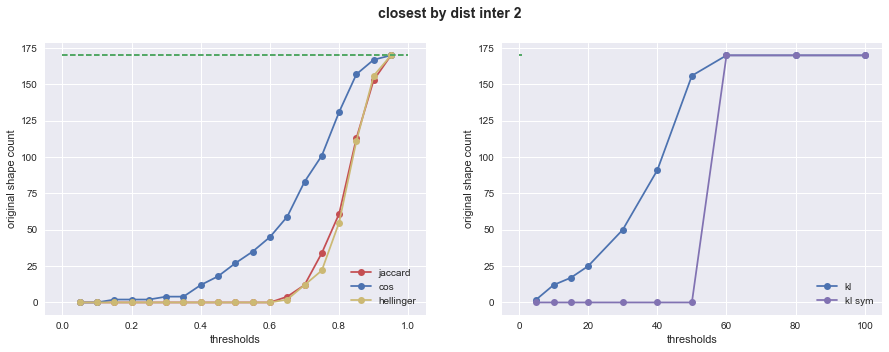

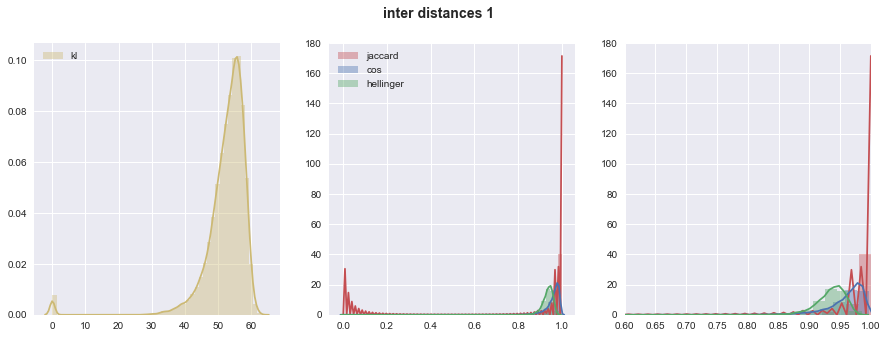

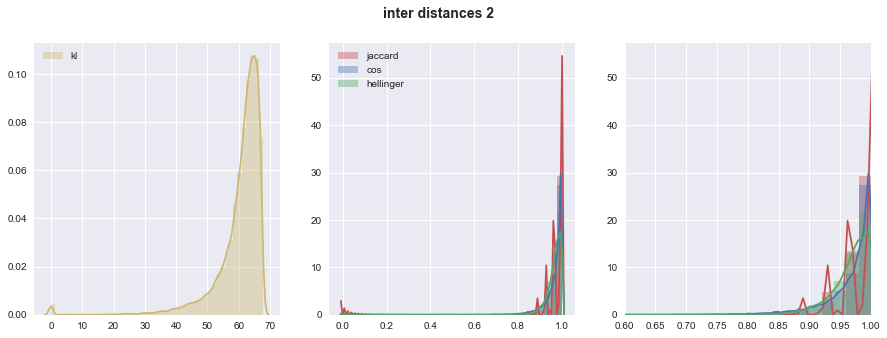

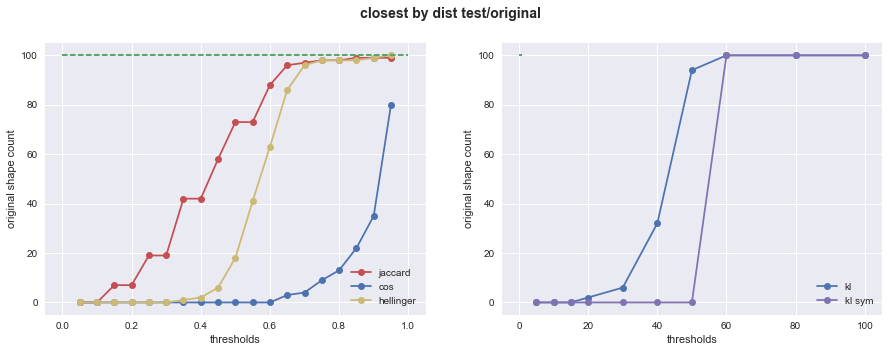

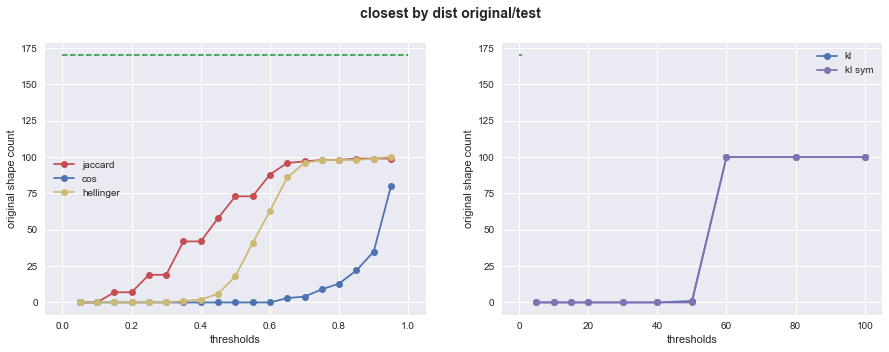

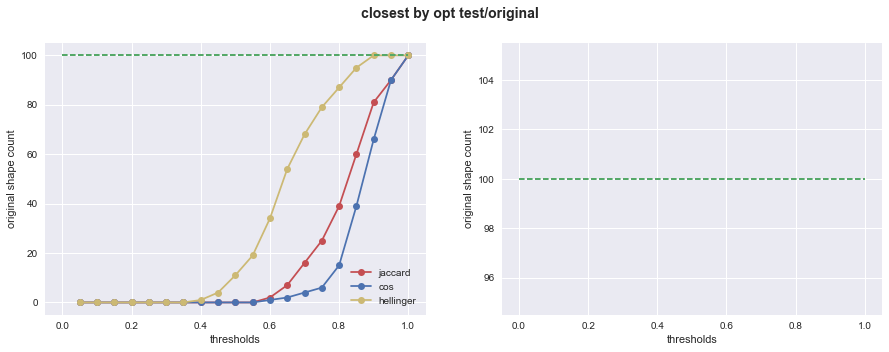

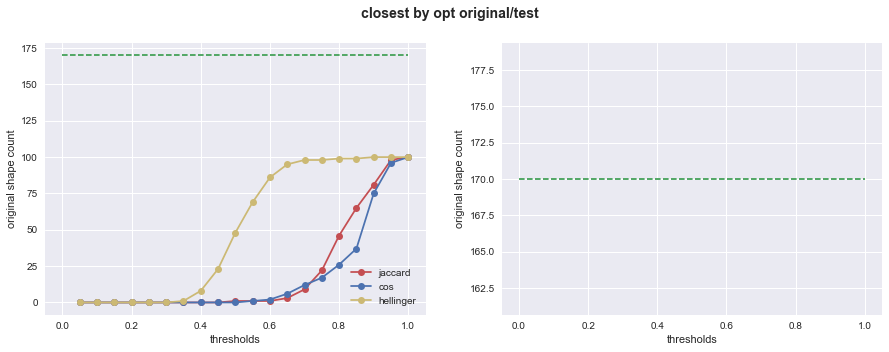

In [31]:
def create_model_rch_300_2_decor_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 42
names_list[idx] = u'create_model_rch_300_2_decor_ts'
models_list[idx] = create_model_rch_300_2_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [19]:
idx = 42
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_rch_300_2_decor_ts          -            -            -        -
300 -> 170, 1.00                  24 vs 16  .63 vs 0.48  .78 vs 0.73    -----
closest by dist test/original        j7-h0       j42-h2      j88-h63     jh98
closest by dist original/test        j7-h0       j42-h2      j88-h63     jh98
closest by opt res test/original       jh0        j0-h1       j2-h34  j39-h87
closest by opt res original/test       jh0        j0-h8       j1-h86  j46-h99

name = create_model_rch_300_3_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_300_3_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

name = create_model_rch_300_3_decor_ts_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.9
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 196, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_20', u'topic_21', u'topic

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   196.00
non zero ratio                    0.96     0.99
|phi_ij == 0| / n_topics       7689.02  8010.40
|phi_ij > 0.2| / n_topics         0.03     0.31
|phi_ij > 0.1| / n_topics         0.31     1.53
|phi_ij > 0.01| / n_topics       14.64    22.90
|phi_ij > 0.05| / n_topics        1.21     5.13
|phi_ij > 0.001| / n_topics     214.17    39.43
topic_kernel_average_size        23.68    15.77
topic_kernel_average_purity       0.63     0.44
topic_kernel_average_contrast     0.78     0.67

Dist fn = <function kl_sym_dist at 0x000000000BF32978>, Processed th = 100, original columns count = 196        Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Processing <function jaccard_dist at 0x000000000BF329E8>
Processing <function cos_dist at 0x000000000BF32AC8>
Processing <function hellinger_dist at 0x000000000BF32B38>
Processing <function kl_dist at 0x000000000BF32908>
Processing <function kl_sym_dist at 0x000000000BF32978>
Dist fn = <function cos_dist at 0x000000000BF32AC8>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_5 not optimized
Column topic_7 not optimized
Column topic_12 not optimized
Column topic_15 not optimized
Column topic_16 not optimized
Column topic_23 not optimized
Column topic_25

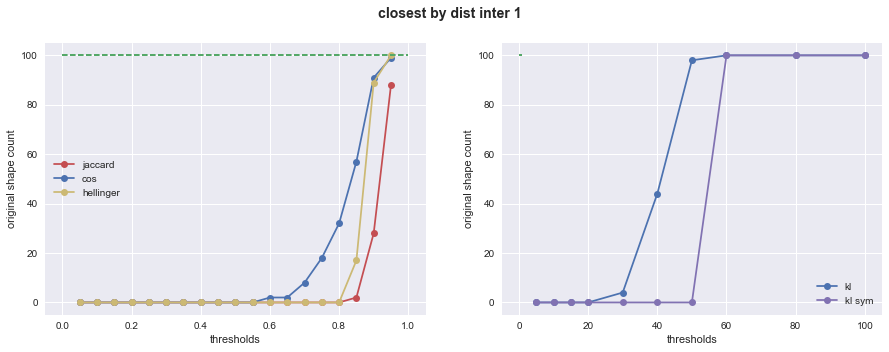

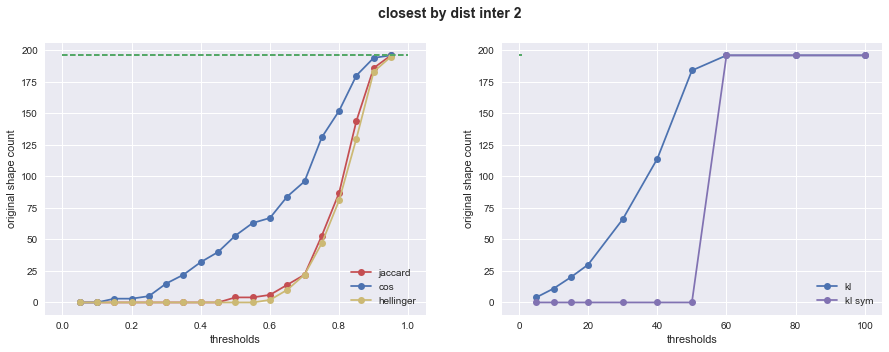

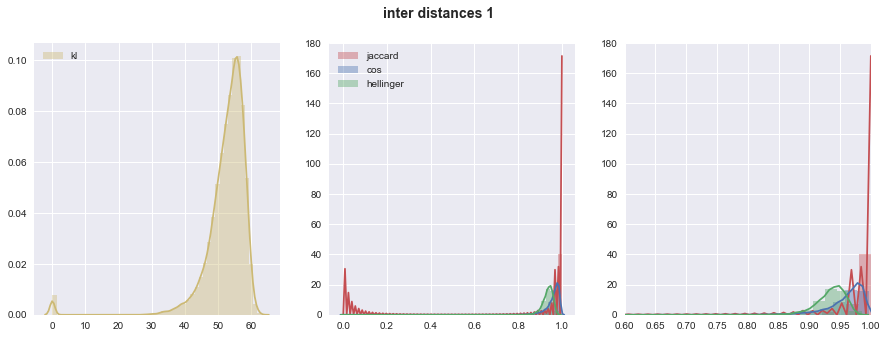

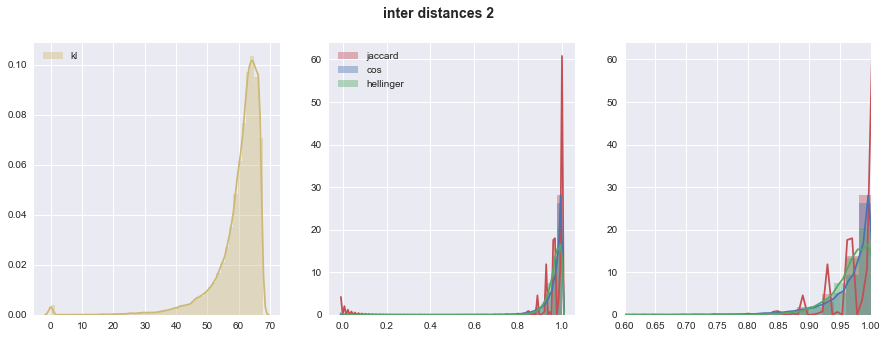

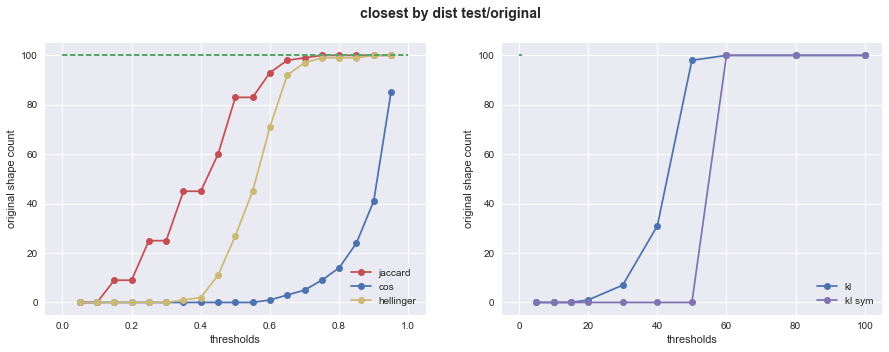

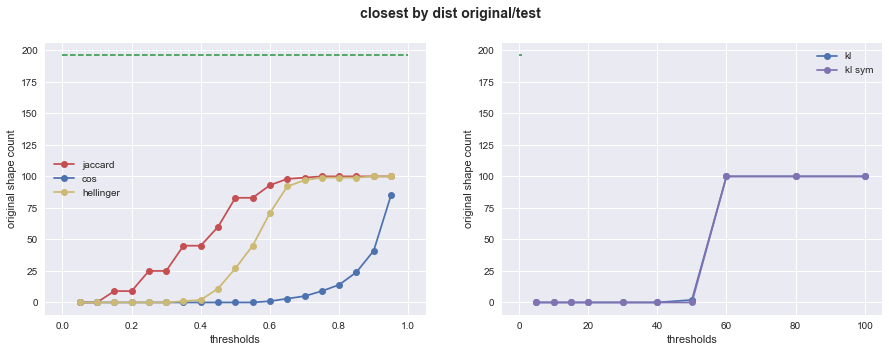

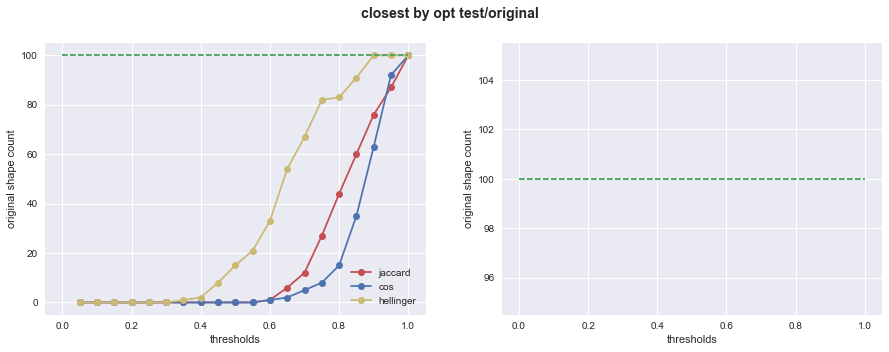

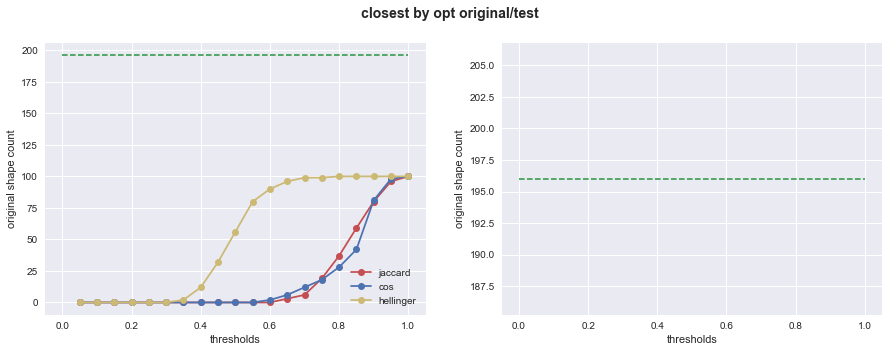

In [32]:
def create_model_rch_300_3_decor_ts(n_iteration, model_name='', fit=True, n_topics=N_TOPICS):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.9
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_300_3_decor_ts'
models_list[idx] = create_model_rch_300_3_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [20]:
idx = 41
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS,
                first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
create_model_rch_300_3_decor_ts          -            -            -         -
300 -> 196, 0.99                  24 vs 16  .63 vs 0.44  .78 vs 0.67     -----
closest by dist test/original        j9-h0       j45-h2      j93-h71  j100-h99
closest by dist original/test        j9-h0       j45-h2      j93-h71  j100-h99
closest by opt res test/original       jh0        j0-h2       j1-h33   j44-h83
closest by opt res original/test       jh0       j0-h12       j0-h90  j37-h100

In [33]:
save_pickle_file([different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix], 'result_300.p')
save_pickle_file([names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list], 'init_300.p')

In [21]:
result_dfs_nz = [item for item in result_dfs if type(item) != int]
result_dfs_nz = pd.concat(result_dfs_nz)
result_dfs_nz

0.2          0.4          0.6       0.8
model_rch_300_1                          -            -            -         -
300 -> 55, 1.00                   24 vs 11  .63 vs 0.54  .78 vs 0.70     -----
closest by dist test/original          jh0          jh0       j12-h2      jh44
closest by dist original/test          jh0          jh0       j12-h2      jh44
closest by opt res test/original       jh0          jh0        j3-h4   j34-h52
closest by opt res original/test       jh0          jh0        j0-h6    j5-h41
model_rch_300_2                          -            -            -         -
300 -> 198, 0.99                  24 vs 15  .63 vs 0.36  .78 vs 0.65     -----
closest by dist test/original        j7-h0       j45-h2      j89-h72  j100-h99
closest by dist original/test        j7-h0       j45-h2      j89-h72  j100-h99
closest by opt res test/original       jh0        j0-h2       j5-h35   j49-h90
closest by opt res original/test       jh0        j0-h8       j0-h89  j35-h100
model_rch_300_3                          -            -            -         -
300 -> 199, 0.99                  24 vs 15  .63 vs 0.37  .78 vs 0.65     -----
closest by dist test/original        j6-h0       j44-h2      j90-h73  j100-h99
closest by dist original/test        j6-h0       j44-h2      j90-h73  j100-h99
closest by opt res test/original       jh0        j0-h2       j3-h34   j48-h88
closest by opt res original/test       jh0        j0-h8       j0-h89  j46-h100
model_rch_300_4                          -            -            -         -
300 -> 54, 1.00                   24 vs 11  .63 vs 0.56  .78 vs 0.68     -----
closest by dist test/original          jh0          jh0       j12-h2   j43-h45
closest by dist original/test          jh0          jh0       j12-h2   j43-h45
closest by opt res test/original       jh0          jh0          jh3   j34-h50
closest by opt res original/test       jh0          jh0        j0-h5    j5-h40
model_rch_300_1_ts                       -            -            -         -
300 -> 43, 0.99                   24 vs 15  .63 vs 0.62  .78 vs 0.68     --+--
closest by dist test/original          jh0          jh0        j6-h1   j30-h36
closest by dist original/test          jh0          jh0        j6-h1   j30-h36
closest by opt res test/original       jh0          jh0        j1-h3   j31-h42
closest by opt res original/test       jh0          jh0        j0-h5    j2-h30
model_rch_300_2_ts                       -            -            -         -
300 -> 175, 0.99                  24 vs 17  .63 vs 0.35  .78 vs 0.68     -----
closest by dist test/original        j7-h0       j41-h2      j89-h76  j100-h99
closest by dist original/test        j7-h0       j41-h2      j89-h76  j100-h99
closest by opt res test/original       jh0        j0-h1       j4-h46   j49-h96
closest by opt res original/test       jh0        j0-h9       j0-h86   j37-h99
model_rch_300_3_ts                       -            -            -         -
300 -> 154, 0.99                  24 vs 17  .63 vs 0.39  .78 vs 0.71     -----
closest by dist test/original        j3-h0       j44-h1      j88-h76  j100-h98
closest by dist original/test        j3-h0       j44-h1      j88-h76  j100-h98
closest by opt res test/original       jh0          jh0       j5-h52   j52-h93
closest by opt res original/test       jh0        j0-h3       j0-h84  j37-h100
model_rch_300_4_ts                       -            -            -         -
300 -> 139, 0.99                  24 vs 19  .63 vs 0.44  .78 vs 0.75     -----
closest by dist test/original        j6-h0       j37-h1      j88-h78   j97-h98
closest by dist original/test        j6-h0       j37-h1      j88-h78   j97-h98
closest by opt res test/original       jh0          jh0       j2-h61   j55-h96
closest by opt res original/test       jh0        j0-h4       j0-h85   j30-h98
model_rch_300_5_ts                       -            -            -         -
300 -> 214, 0.97                  24 vs 22  .63 vs 0.51  .78 vs 0.68     -----
closest by